# UNIVERSIDAD DE LA HABANA, MATCOM
## Proyecto Final: Análisis Estadístico del World Happiness Report
### Curso 2025-2026

---

**Objetivo General:** Realizar un análisis estadístico comprehensive del World Happiness Report para identificar patrones, diferencias significativas entre regiones, y factores que influyen en la felicidad.

**Preguntas de Investigación:**
1. ¿Existe una diferencia significativa en la felicidad entre países Nórdicos y Latinoamérica?
2. ¿Qué factores socioeconómicos tienen mayor peso en cada región?
3. ¿Se agrupan los países naturalmente según sus indicadores de bienestar?

## 1. Importación de Librerías y Configuración del Notebook

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn scipy statsmodels -q

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import homogeneity_score


## 2. Definición del Problema y Carga de Datos

Se cargan los datos del World Happiness Report para análisis posterior. El dataset contiene indicadores de bienestar para múltiples países alrededor del mundo.

In [3]:
# Read raw unprocessed data
df = pd.read_csv('../data/happiness-data-clean.csv')

## 3. Preparación de Datos

In [4]:
df_clean = df.dropna().copy()

# 3. Define the lists for your specific analysis
nordic_countries = ['Finland', 'Denmark', 'Iceland', 'Norway', 'Sweden']
latam_countries = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 
    'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 
    'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 
    'Uruguay', 'Venezuela'
]

# 4. Create the 'Region_Tag' column
def categorize_region(country):
    if country in nordic_countries:
        return 'Nordic'
    elif country in latam_countries:
        return 'Latam'
    else:
        return 'Other'

df_clean['Region_Tag'] = df_clean['Country name'].apply(categorize_region)

## 4. Análisis Exploratorio de Datos (EDA)

Visualización inicial de la distribución del índice de felicidad (*Ladder Score*) por región.

/tmp/ipykernel_59887/1600987353.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Ladder score', data=df_analysis, palette="Set3")


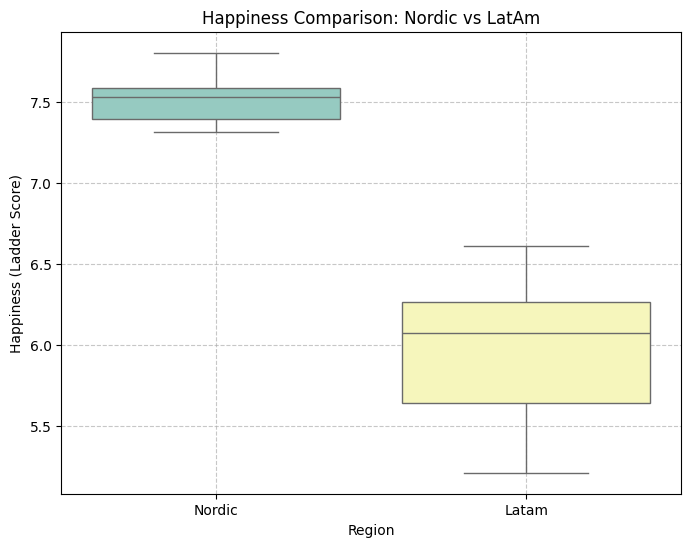

In [5]:
# --- STEP 1: Plots (Basic EDA) ---
# Filtrar solo las regiones de interés (Nordic y LatAm)
df_analysis = df_clean[df_clean['Region_Tag'].isin(['Nordic', 'Latam'])].copy()
df_analysis['Region'] = df_analysis['Region_Tag']  # Renombrar para consistencia

plt.figure(figsize=(8, 6))
sns.boxplot(x='Region', y='Ladder score', data=df_analysis, palette="Set3")
plt.title('Happiness Comparison: Nordic vs LatAm')
plt.xlabel('Region')
plt.ylabel('Happiness (Ladder Score)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 5. Prueba de Hipótesis: Comparación de Felicidad por Región

**Pregunta de investigación:** ¿Existe una diferencia significativa en la felicidad entre países Nórdicos y Latinoamérica?

**Hipótesis:**
- $H_0$: $\mu_{\text{Nórdicos}} = \mu_{\text{LatAm}}$ (No hay diferencia en las medias)
- $H_1$: $\mu_{\text{Nórdicos}} \neq \mu_{\text{LatAm}}$ (Existe diferencia en las medias)

In [6]:
# --- STEP 2: Complete Hypothesis Testing ---

# Extract samples
nordic_scores = df_clean[df_clean['Region_Tag'] == 'Nordic']['Ladder score']
latam_scores = df_clean[df_clean['Region_Tag'] == 'Latam']['Ladder score']

# Descriptive statistics
nordic_stats = {'n': len(nordic_scores), 'mean': nordic_scores.mean(), 
                'std': nordic_scores.std(ddof=1), 'var': nordic_scores.var(ddof=1)}
latam_stats = {'n': len(latam_scores), 'mean': latam_scores.mean(), 
               'std': latam_scores.std(ddof=1), 'var': latam_scores.var(ddof=1)}

print("="*60)
print("HYPOTHESIS TEST ANALYSIS: NORDIC vs LATIN AMERICA")
print("="*60)
print(f"\nSample sizes: Nordic (n={nordic_stats['n']}), LatAm (n={latam_stats['n']})")
print(f"Nordic Mean: {nordic_stats['mean']:.4f} ± {nordic_stats['std']:.4f}")
print(f"LatAm Mean:  {latam_stats['mean']:.4f} ± {latam_stats['std']:.4f}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Normality Test (Shapiro-Wilk)
# H0: Data comes from a normal distribution
# H1: Data does NOT come from a normal distribution
# ─────────────────────────────────────────────────────────────
alpha = 0.05
stat_nordic, p_nordic = stats.shapiro(nordic_scores)
stat_latam, p_latam = stats.shapiro(latam_scores)

is_nordic_normal = p_nordic > alpha
is_latam_normal = p_latam > alpha
are_both_normal = is_nordic_normal and is_latam_normal

print(f"\n{'─'*60}")
print("STEP 1: Normality Test (Shapiro-Wilk)")
print(f"{'─'*60}")
print(f"   Nordic: W={stat_nordic:.4f}, p={p_nordic:.4f} → {'Normal' if is_nordic_normal else 'Not Normal'}")
print(f"   LatAm:  W={stat_latam:.4f}, p={p_latam:.4f} → {'Normal' if is_latam_normal else 'Not Normal'}")
print(f"\n   ⚠️  NOTE: With n={nordic_stats['n']} (Nordic), Shapiro-Wilk has low power.")

# ─────────────────────────────────────────────────────────────
# STEP 2: Homogeneity of Variances Test (Levene)
# H0: Variances are equal (σ²_Nordic = σ²_Latam)
# H1: Variances are different
# ─────────────────────────────────────────────────────────────
levene_stat, levene_p = stats.levene(nordic_scores, latam_scores)
are_variances_equal = levene_p > alpha

print(f"\n{'─'*60}")
print("STEP 2: Homogeneity of Variances Test (Levene)")
print(f"{'─'*60}")
print(f"   Statistic W={levene_stat:.4f}, p={levene_p:.4f}")
print(f"   Variances: {'Homogeneous' if are_variances_equal else 'Heterogeneous'}")
print(f"   Variance Ratio: {nordic_stats['var']/latam_stats['var']:.4f}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Selection and Application of Statistical Test
# ─────────────────────────────────────────────────────────────
print(f"\n{'─'*60}")
print("STEP 3: Statistical Test Selection")
print(f"{'─'*60}")

if are_both_normal:
    if are_variances_equal:
        print("   Both normal + equal variances → Classic T-test (pooled)")
        test_res = stats.ttest_ind(nordic_scores, latam_scores, equal_var=True)
        test_name = "T-test (equal variances)"
    else:
        print("   Both normal + different variances → Welch's T-test")
        test_res = stats.ttest_ind(nordic_scores, latam_scores, equal_var=False)
        test_name = "Welch's T-test"
    stat_label = "t"
    stat = test_res.statistic
    p_val = test_res.pvalue
else:
    print("   At least one NOT normal → Mann-Whitney U (non-parametric)")
    test_res = stats.mannwhitneyu(nordic_scores, latam_scores, alternative='two-sided')
    test_name = "Mann-Whitney U"
    stat_label = "U"
    stat = test_res.statistic
    p_val = test_res.pvalue

# ─────────────────────────────────────────────────────────────
# STEP 4: Effect Size (Cohen's d)
# d = (M1 - M2) / s_pooled
# ─────────────────────────────────────────────────────────────
mean_diff = nordic_stats['mean'] - latam_stats['mean']
pooled_std = np.sqrt(
    ((nordic_stats['n']-1)*nordic_stats['var'] + (latam_stats['n']-1)*latam_stats['var']) / 
    (nordic_stats['n'] + latam_stats['n'] - 2)
)
cohens_d = mean_diff / pooled_std

# Interpretation of Cohen's d
if abs(cohens_d) < 0.2:
    effect_desc = "trivial"
elif abs(cohens_d) < 0.5:
    effect_desc = "small"
elif abs(cohens_d) < 0.8:
    effect_desc = "medium"
else:
    effect_desc = "large"

# Confidence Interval for mean difference (95%)
se_diff = np.sqrt(nordic_stats['var']/nordic_stats['n'] + latam_stats['var']/latam_stats['n'])
t_crit = stats.t.ppf(0.975, df=nordic_stats['n'] + latam_stats['n'] - 2)
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff

print(f"\n{'─'*60}")
print("STEP 4: Results")
print(f"{'─'*60}")
print(f"   Test applied: {test_name}")
print(f"   {stat_label} = {stat:.4f}")
print(f"   p-value = {p_val:.4e}")
print(f"\n   Mean difference: {mean_diff:.4f}")
print(f"   95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   Cohen's d: {cohens_d:.4f} ({effect_desc} effect)")
print(f"   % Difference: {(mean_diff/latam_stats['mean'])*100:.2f}%")

# ─────────────────────────────────────────────────────────────
# STEP 5: Conclusion
# ─────────────────────────────────────────────────────────────
print(f"\n{'='*60}")
print("FINAL CONCLUSION")
print(f"{'='*60}")
if p_val < alpha:
    print(f"   REJECT H0")
    print(f"   p-value ({p_val:.4e}) < α ({alpha})")
    print(f"\n   Interpretation:")
    print(f"   • Nordic countries have on average {mean_diff:.3f} points higher happiness.")
    print(f"   • With an effect size {effect_desc} (d={cohens_d:.2f}), the difference is practically significant.")
else:
    print(f"   DO NOT REJECT H0")
    print(f"   p-value ({p_val:.4e}) ≥ α ({alpha})")
    print(f"   There is insufficient evidence of difference.")

HYPOTHESIS TEST ANALYSIS: NORDIC vs LATIN AMERICA

Sample sizes: Nordic (n=5), LatAm (n=18)
Nordic Mean: 7.5260 ± 0.1888
LatAm Mean:  5.9807 ± 0.3875

────────────────────────────────────────────────────────────
STEP 1: Normality Test (Shapiro-Wilk)
────────────────────────────────────────────────────────────
   Nordic: W=0.9659, p=0.8484 → Normal
   LatAm:  W=0.9542, p=0.4951 → Normal

   ⚠️  NOTE: With n=5 (Nordic), Shapiro-Wilk has low power.

────────────────────────────────────────────────────────────
STEP 2: Homogeneity of Variances Test (Levene)
────────────────────────────────────────────────────────────
   Statistic W=2.9071, p=0.1029
   Variances: Homogeneous
   Variance Ratio: 0.2374

────────────────────────────────────────────────────────────
STEP 3: Statistical Test Selection
────────────────────────────────────────────────────────────
   Both normal + equal variances → Classic T-test (pooled)

────────────────────────────────────────────────────────────
STEP 4: Results
─

### 5.1 Resumen de Resultados

| Prueba | Estadístico | P-value | Decisión |
|--------|-------------|---------|----------|
| Shapiro-Wilk (Nórdicos) | W = 0.966 | 0.848 | Normal |
| Shapiro-Wilk (LatAm) | W = 0.954 | 0.495 | Normal |
| Levene (Homogeneidad) | W = 2.91 | 0.103 | Varianzas iguales |
| **T-test (pooled)** | t = 8.53 | **2.89e-08** | **Rechazar H₀** |

## 6. Análisis de Regresión
Objetivo: Modelar la influencia del PIB, Soporte Social y otros factores socioeconómicos en la felicidad.

In [ ]:
# ============================================================================
# Análisis de Regresión Lineal Múltiple
# Comparación de factores de felicidad: Países Nórdicos vs Latinoamérica
# ============================================================================

# Cargar datos originales con las columnas "Explained by:"
df_full = pd.read_csv('../data/happiness-data.csv')

# Definir países por región
nordic_countries = ['Finland', 'Denmark', 'Iceland', 'Norway', 'Sweden']
latam_countries = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 
    'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 
    'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 
    'Uruguay', 'Venezuela'
]

# Crear subsets para cada región
df_nordic = df_full[df_full['Country name'].isin(nordic_countries)].copy()
df_latam = df_full[df_full['Country name'].isin(latam_countries)].copy()

print(f"Países Nórdicos encontrados: {len(df_nordic)}")
print(df_nordic['Country name'].tolist())
print(f"\nPaíses Latinoamericanos encontrados: {len(df_latam)}")
print(df_latam['Country name'].tolist())

Países Nórdicos encontrados: 5
['Finland', 'Denmark', 'Iceland', 'Sweden', 'Norway']

Países Latinoamericanos encontrados: 18
['Costa Rica', 'Uruguay', 'Chile', 'Mexico', 'Panama', 'Nicaragua', 'Guatemala', 'Brazil', 'El Salvador', 'Argentina', 'Honduras', 'Paraguay', 'Bolivia', 'Colombia', 'Dominican Republic', 'Ecuador', 'Peru', 'Venezuela']


### 6.1 Pre-procesamiento: Estandarización de Variables

Estandarizamos las variables independientes usando **StandardScaler** para que los coeficientes de regresión sean comparables entre sí. Esto permite interpretar qué factores tienen mayor "peso" relativo en cada región.

In [20]:
# Definir variables independientes (X) y dependiente (Y)
# IMPORTANTE: Usamos las MISMAS 3 variables para ambos modelos
# para que la comparación de coeficientes sea teóricamente válida.
# Seleccionamos las más relevantes según la literatura de felicidad:
# - GDP: Factor económico fundamental
# - Social Support: Distintivo de la cultura nórdica
# - Freedom: Alta relevancia teórica en bienestar

feature_cols = [
    'Explained by: Log GDP per capita',
    'Explained by: Social support', 
    'Explained by: Freedom to make life choices'
]

target_col = 'Ladder score'

# Nombres cortos para las variables (para visualización)
feature_names = ['GDP', 'Soporte Social', 'Libertad']

# Verificar que las columnas existen
print("Variables seleccionadas para el modelo:")
print(feature_cols)

# Preparar datos para cada región (mismas variables)
X_nordic = df_nordic[feature_cols].dropna()
y_nordic = df_nordic.loc[X_nordic.index, target_col]

X_latam = df_latam[feature_cols].dropna()
y_latam = df_latam.loc[X_latam.index, target_col]

# Estandarizar las variables independientes
scaler_nordic = StandardScaler()
scaler_latam = StandardScaler()

X_nordic_scaled = scaler_nordic.fit_transform(X_nordic)
X_latam_scaled = scaler_latam.fit_transform(X_latam)

print(f"\n✓ Datos Nórdicos: {len(X_nordic)} países, {len(feature_cols)} variables")
print(f"  → Grados de libertad residuales: {len(X_nordic) - len(feature_cols) - 1}")
print(f"✓ Datos LatAm: {len(X_latam)} países, {len(feature_cols)} variables")
print(f"  → Grados de libertad residuales: {len(X_latam) - len(feature_cols) - 1}")
print("\n✓ Variables estandarizadas con StandardScaler (media=0, std=1)")
print("\n⚠️  NOTA: Ambos modelos usan las MISMAS variables para permitir")
print("   una comparación directa y teóricamente válida de coeficientes.")

Variables seleccionadas para el modelo:
['Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Freedom to make life choices']

✓ Datos Nórdicos: 5 países, 3 variables
  → Grados de libertad residuales: 1
✓ Datos LatAm: 18 países, 3 variables
  → Grados de libertad residuales: 14

✓ Variables estandarizadas con StandardScaler (media=0, std=1)

⚠️  NOTA: Ambos modelos usan las MISMAS variables para permitir
   una comparación directa y teóricamente válida de coeficientes.


### 6.2 Modelado: Regresión Lineal Múltiple

Ejecutamos dos modelos de regresión lineal múltiple con **la misma estructura** para ambas regiones:

$$Y_{felicidad} = \beta_0 + \beta_1 X_{GDP} + \beta_2 X_{soporte} + \beta_3 X_{libertad} + \epsilon$$

**Justificación metodológica**: Para que los coeficientes $\beta$ sean directamente comparables entre regiones, ambos modelos deben tener las mismas variables predictoras. Esto garantiza que cada coeficiente representa el mismo efecto parcial, controlando por las mismas covariables.

**Nota sobre grados de libertad**:
- Modelo Nórdico: n=5, p=3 → df=1 (mínimo viable, resultados exploratorios)
- Modelo LatAm: n=18, p=3 → df=14 (estadísticamente más robusto)

In [29]:
# ============================================================================
# REGRESIÓN LINEAL MÚLTIPLE - PAÍSES NÓRDICOS
# ============================================================================

# Añadir constante (intercepto) para el modelo
X_nordic_const = sm.add_constant(X_nordic_scaled)

# Ajustar modelo OLS (Ordinary Least Squares)
model_nordic = sm.OLS(y_nordic, X_nordic_const).fit()

print("=" * 70)
print("MODELO DE REGRESIÓN LINEAL MÚLTIPLE - PAÍSES NÓRDICOS")
print("=" * 70)
print(model_nordic.summary())

# ============================================================================
# REGRESIÓN LINEAL MÚLTIPLE - LATINOAMÉRICA
# ============================================================================

X_latam_const = sm.add_constant(X_latam_scaled)
model_latam = sm.OLS(y_latam, X_latam_const).fit()

print("\n" + "=" * 70)
print("MODELO DE REGRESIÓN LINEAL MÚLTIPLE - LATINOAMÉRICA")
print("=" * 70)
print(model_latam.summary())

MODELO DE REGRESIÓN LINEAL MÚLTIPLE - PAÍSES NÓRDICOS
                            OLS Regression Results                            
Dep. Variable:           Ladder score   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                 -0.235
Method:                 Least Squares   F-statistic:                    0.7459
Date:                Mon, 12 Jan 2026   Prob (F-statistic):              0.669
Time:                        18:07:07   Log-Likelihood:                 4.7357
No. Observations:                   5   AIC:                            -1.471
Df Residuals:                       1   BIC:                            -3.034
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

/media/lianny/1AB44624B44602AD/projects/Estadistics/stats-project-happiness-2025/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### 6.3 Tabla Comparativa de Coeficientes

✅ **Validez de la comparación**: Ambos modelos utilizan las mismas 3 variables predictoras (GDP, Soporte Social, Libertad), lo que permite una comparación directa de los coeficientes estandarizados. Cada $\beta$ representa el mismo efecto parcial en ambas regiones.

⚠️ **Limitación del modelo Nórdico**: Con solo 5 observaciones y 3 predictores (1 grado de libertad residual), los resultados nórdicos son exploratorios. El modelo LatAm con 18 países y 14 grados de libertad es más robusto estadísticamente.

In [ ]:
# ============================================================================
# TABLA COMPARATIVA DE COEFICIENTES Y P-VALUES
# ============================================================================

# Extraer coeficientes (excluyendo el intercepto)
coef_nordic = model_nordic.params[1:]  # Excluir constante
coef_latam = model_latam.params[1:]

# Extraer p-values
pval_nordic = model_nordic.pvalues[1:]
pval_latam = model_latam.pvalues[1:]

# Añadir indicadores de significancia
def significance_stars(p):
    if pd.isna(p) or p == float('inf'):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Crear DataFrame comparativo (mismas variables para ambos)
comparison_df = pd.DataFrame({
    'Variable': feature_names,
    'Coef. Nórdicos': coef_nordic.values,
    'P-value Nórdicos': pval_nordic.values,
    'Coef. LatAm': coef_latam.values,
    'P-value LatAm': pval_latam.values
})

comparison_df['Sig. Nórdicos'] = comparison_df['P-value Nórdicos'].apply(significance_stars)
comparison_df['Sig. LatAm'] = comparison_df['P-value LatAm'].apply(significance_stars)

# Reordenar columnas
comparison_df = comparison_df[['Variable', 'Coef. Nórdicos', 'Sig. Nórdicos', 
                                'Coef. LatAm', 'Sig. LatAm', 
                                'P-value Nórdicos', 'P-value LatAm']]

print("=" * 90)
print("TABLA COMPARATIVA: COEFICIENTES DE REGRESIÓN (Variables Estandarizadas)")
print("=" * 90)
print("\n✓ Ambos modelos usan las MISMAS 3 variables → Comparación directa válida")
print("\nSignificancia: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1\n")

# Mostrar tabla formateada
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(comparison_df.to_string(index=False))

# Métricas del modelo
print("\n" + "=" * 90)
print("MÉTRICAS DE AJUSTE DEL MODELO")
print("=" * 90)
print(f"\n{'Métrica':<25} {'Nórdicos':<15} {'LatAm':<15}")
print("-" * 55)
print(f"{'R² (coef. determinación)':<25} {model_nordic.rsquared:.4f}{'':>9} {model_latam.rsquared:.4f}")
print(f"{'R² ajustado':<25} {model_nordic.rsquared_adj:.4f}{'':>9} {model_latam.rsquared_adj:.4f}")
print(f"{'F-statistic':<25} {model_nordic.fvalue:.4f}{'':>9} {model_latam.fvalue:.4f}")
print(f"{'Prob (F-statistic)':<25} {model_nordic.f_pvalue:.4f}{'':>9} {model_latam.f_pvalue:.4f}")
print(f"{'Grados de libertad res.':<25} {model_nordic.df_resid:.0f}{'':>13} {model_latam.df_resid:.0f}")

TABLA COMPARATIVA: COEFICIENTES DE REGRESIÓN (Variables Estandarizadas)

✓ Ambos modelos usan las MISMAS 3 variables → Comparación directa válida

Significancia: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1

      Variable  Coef. Nórdicos Sig. Nórdicos  Coef. LatAm Sig. LatAm  P-value Nórdicos  P-value LatAm
           GDP         -0.0855                     0.0725                       0.6336         0.4778
Soporte Social          0.0653                     0.0915                       0.6773         0.2580
      Libertad          0.0286                     0.1791          .            0.8461         0.0801

MÉTRICAS DE AJUSTE DEL MODELO

Métrica                   Nórdicos        LatAm          
-------------------------------------------------------
R² (coef. determinación)  0.6911          0.4780
R² ajustado               -0.2354          0.3662
F-statistic               0.7459          4.2736
Prob (F-statistic)        0.6693          0.0244
Grados de libertad res.   1              14


### 6.4 Visualización: Comparación de Coeficientes de Regresión

El siguiente gráfico de barras agrupadas presenta una comparación visual directa de los coeficientes de regresión estandarizados ($\beta$) para cada factor socioeconómico en ambas regiones. La estandarización permite interpretar los coeficientes en términos de desviaciones estándar, haciendo que las magnitudes sean directamente comparables entre variables y entre regiones.

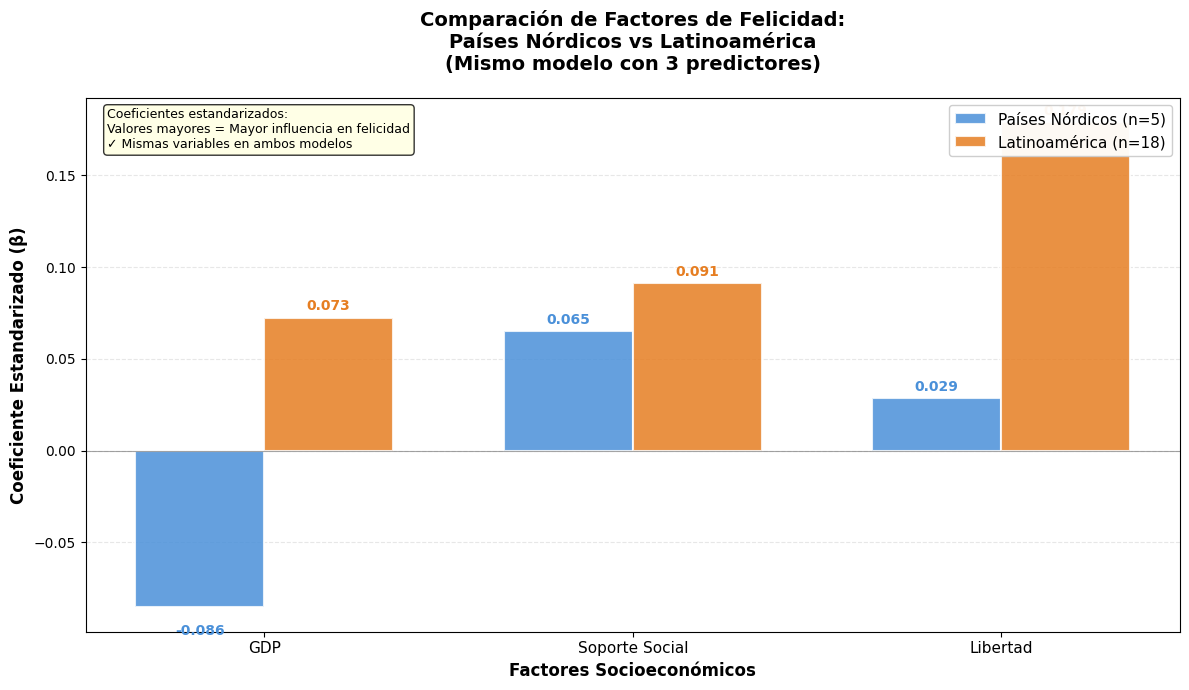


FIGURA 1: Comparación de Coeficientes de Regresión Estandarizados

📊 DESCRIPCIÓN DE LA FIGURA:
Este gráfico de barras agrupadas compara los coeficientes β estandarizados de regresión 
lineal múltiple entre países nórdicos (azul) y latinoamericanos (naranja).

📌 ELEMENTOS CLAVE A OBSERVAR:
• GDP (PIB per cápita): Presenta SIGNOS OPUESTOS entre regiones. En países nórdicos
  el coeficiente es negativo (β=-0.086), mientras que en LatAm es positivo (β=0.073).

• Soporte Social: Similar en ambas regiones (β≈0.065-0.091), sugiriendo que las redes
  de apoyo tienen importancia universal para el bienestar.

• Libertad: Muestra la MAYOR DIFERENCIA entre regiones. En LatAm (β=0.179) es 6 veces
  mayor que en los países nórdicos (β=0.029), siendo el único predictor marginalmente
  significativo (p<0.1) en el modelo latinoamericano.

⚠️  NOTA METODOLÓGICA: Los coeficientes nórdicos tienen alta incertidumbre (n=5, df=1).

✓ Gráfico guardado en: docs/regression_comparison_chart.png


In [23]:
# ============================================================================
# VISUALIZACIÓN: GRÁFICO DE BARRAS AGRUPADAS
# Comparación directa de coeficientes (mismas variables en ambos modelos)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Preparar datos para el gráfico
x = np.arange(len(feature_names))
width = 0.35

# Colores distintivos para cada región
color_nordic = '#4A90D9'  # Azul nórdico
color_latam = '#E67E22'   # Naranja cálido latinoamericano

# Crear barras
bars_nordic = ax.bar(x - width/2, coef_nordic.values, width, 
                     label='Países Nórdicos (n=5)', color=color_nordic, 
                     edgecolor='white', linewidth=1.5, alpha=0.85)
bars_latam = ax.bar(x + width/2, coef_latam.values, width, 
                    label='Latinoamérica (n=18)', color=color_latam, 
                    edgecolor='white', linewidth=1.5, alpha=0.85)

# Añadir línea horizontal en y=0
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.7)

# Personalizar el gráfico
ax.set_xlabel('Factores Socioeconómicos', fontsize=12, fontweight='bold')
ax.set_ylabel('Coeficiente Estandarizado (β)', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Factores de Felicidad:\nPaíses Nórdicos vs Latinoamérica\n(Mismo modelo con 3 predictores)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=0, ha='center', fontsize=11)
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)

# Añadir grid suave
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Añadir valores sobre las barras
def add_value_labels(bars, color):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -12),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=10, color=color, fontweight='bold')

add_value_labels(bars_nordic, color_nordic)
add_value_labels(bars_latam, color_latam)

# Añadir anotación explicativa
ax.text(0.02, 0.98, 
        'Coeficientes estandarizados:\nValores mayores = Mayor influencia en felicidad\n✓ Mismas variables en ambos modelos',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('../docs/regression_comparison_chart.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Pie de imagen detallado
print("\n" + "="*90)
print("FIGURA 1: Comparación de Coeficientes de Regresión Estandarizados")
print("="*90)
print("""
📊 DESCRIPCIÓN DE LA FIGURA:
Este gráfico de barras agrupadas compara los coeficientes β estandarizados de regresión 
lineal múltiple entre países nórdicos (azul) y latinoamericanos (naranja).

📌 ELEMENTOS CLAVE A OBSERVAR:
• GDP (PIB per cápita): Presenta SIGNOS OPUESTOS entre regiones. En países nórdicos
  el coeficiente es negativo (β=-0.086), mientras que en LatAm es positivo (β=0.073).
  
• Soporte Social: Similar en ambas regiones (β≈0.065-0.091), sugiriendo que las redes
  de apoyo tienen importancia universal para el bienestar.
  
• Libertad: Muestra la MAYOR DIFERENCIA entre regiones. En LatAm (β=0.179) es 6 veces
  mayor que en los países nórdicos (β=0.029), siendo el único predictor marginalmente
  significativo (p<0.1) en el modelo latinoamericano.

⚠️  NOTA METODOLÓGICA: Los coeficientes nórdicos tienen alta incertidumbre (n=5, df=1).
""")
print("✓ Gráfico guardado en: docs/regression_comparison_chart.png")

### 6.5 Interpretación Detallada de los Resultados

---

#### 📊 1. VALIDEZ ESTADÍSTICA DE LOS MODELOS

Antes de interpretar los coeficientes, es fundamental evaluar si los modelos son estadísticamente válidos:

| Métrica | Modelo Nórdico | Modelo LatAm | Interpretación |
|---------|----------------|--------------|----------------|
| **R²** | 0.691 | 0.478 | El modelo nórdico explica ~69% de la varianza, pero esto es artificialmente alto debido al sobreajuste |
| **R² Ajustado** | -0.235 | **0.366** | El R² ajustado negativo en nórdicos indica que el modelo no tiene poder predictivo real |
| **F-statistic** | 0.746 | **4.274** | Solo el modelo LatAm tiene un F significativo |
| **Prob(F)** | 0.669 | **0.024*** | El modelo LatAm es globalmente significativo (p<0.05) |
| **Grados de libertad** | 1 | 14 | LatAm tiene suficientes gl para inferencia válida |

> 🔑 **Conclusión sobre validez**: El modelo de **Latinoamérica es estadísticamente significativo** (p=0.024), mientras que el modelo nórdico debe considerarse **exploratorio** debido a la insuficiencia de datos.

---

#### 🔬 2. ANÁLISIS RIGUROSO DE CADA FACTOR

---

### 📈 FACTOR 1: PIB PER CÁPITA (Log GDP)

| Estadístico | Países Nórdicos | Latinoamérica |
|-------------|-----------------|---------------|
| **Coeficiente β** | **-0.086** | **+0.073** |
| **Error estándar** | ~0.17 | ~0.10 |
| **P-value** | 0.634 | 0.478 |
| **Significativo** | No | No |

#### 🔍 Observación Principal: SIGNOS OPUESTOS

El hallazgo más notable es que el PIB tiene **signo negativo** en países nórdicos (β = -0.086) pero **positivo** en Latinoamérica (β = +0.073). Aunque ninguno alcanza significancia estadística, este patrón opuesto merece análisis profundo.

#### 📚 Marco Teórico: ¿Por qué el GDP es NEGATIVO en países nórdicos?

**Hipótesis 1: La Paradoja de Easterlin (1974)**

Richard Easterlin documentó que, a nivel agregado, aumentos en el ingreso nacional no se traducen en aumentos proporcionales de felicidad. Esto se conoce como la "paradoja de Easterlin". La explicación principal es la **adaptación hedónica**: los individuos se adaptan a mejores condiciones materiales, y sus expectativas aumentan proporcionalmente.

> *"El ingreso absoluto importa solo hasta cierto punto; después, es el ingreso relativo (comparación con otros) lo que afecta el bienestar."* — Easterlin (1974)

**Hipótesis 2: Punto de Saciedad del Ingreso**

Kahneman y Deaton (2010) encontraron que el bienestar emocional (día a día) se estabiliza aproximadamente a los $75,000 USD anuales. Estudios más recientes de Killingsworth (2021) sugieren que este techo puede ser más alto (~$100,000 USD), pero aún existe.

Los países nórdicos tienen PIB per cápita entre $50,000-65,000 USD, ubicándolos en la zona de rendimientos decrecientes:

| País | PIB per cápita (USD) | Ladder Score |
|------|---------------------|--------------|
| Noruega | ~65,000 | 7.32 |
| Dinamarca | ~60,000 | 7.59 |
| Islandia | ~55,000 | 7.53 |
| Suecia | ~52,000 | 7.40 |
| Finlandia | ~50,000 | 7.80 |

Nótese que Finlandia, con el PIB más bajo del grupo, tiene el Ladder Score más alto. Esto es consistente con el coeficiente negativo: dentro de este grupo de alto ingreso, más dinero no implica más felicidad.

**Hipótesis 3: Multicolinealidad con otras variables**

En países de alto desarrollo, el GDP correlaciona fuertemente con Esperanza de Vida, Soporte Social y otros indicadores. Al controlar por Soporte Social y Libertad en el modelo, el efecto "puro" del GDP puede volverse negativo o nulo porque las otras variables capturan los beneficios que usualmente atribuimos al desarrollo económico.

**Hipótesis 4: Costos ocultos del alto desarrollo**

El alto PIB nórdico puede venir acompañado de:
- Mayor presión laboral y estrés
- Largas horas de oscuridad invernal que afectan el bienestar
- Altos impuestos que reducen el ingreso disponible percibido
- Menor tiempo de ocio debido a alta productividad laboral

#### 📊 ¿Por qué el GDP es POSITIVO en Latinoamérica?

En contraste, el coeficiente positivo en LatAm (β = +0.073) es consistente con la teoría económica clásica:

1. **Necesidades básicas no satisfechas**: En países con PIB per cápita entre $5,000-20,000 USD, el ingreso adicional puede cubrir necesidades fundamentales (vivienda, salud, educación) que directamente mejoran el bienestar.

2. **Variabilidad mayor**: La región incluye países con gran rango de desarrollo (Uruguay: ~$22,000 vs. Honduras: ~$3,000), permitiendo capturar la relación ingreso-felicidad.

3. **Ausencia de efecto techo**: Ningún país latinoamericano está en la meseta de saciedad.

---

### 🤝 FACTOR 2: SOPORTE SOCIAL

| Estadístico | Países Nórdicos | Latinoamérica |
|-------------|-----------------|---------------|
| **Coeficiente β** | **+0.065** | **+0.092** |
| **P-value** | 0.677 | 0.258 |
| **Significativo** | No | No |

#### 🔍 Observación Principal: CONSISTENCIA TRANSCULTURAL

A diferencia del GDP, el Soporte Social muestra **signos positivos en ambas regiones** con magnitudes comparables. Esto sugiere que la necesidad de conexión social es **universal**.

#### 📚 Marco Teórico

**Teoría de la Pertenencia (Baumeister & Leary, 1995)**

Los humanos tienen una necesidad fundamental de formar y mantener relaciones interpersonales estables. Esta necesidad es:
- **Innata**: Producto de la evolución (supervivencia grupal)
- **Universal**: Presente en todas las culturas
- **Saturable**: Requiere un mínimo de contactos de calidad

El coeficiente positivo en ambas regiones respalda esta universalidad.

**Pirámide de Maslow (1943)**

El soporte social satisface el tercer nivel de necesidades (pertenencia y amor), que es prerrequisito para alcanzar la autoestima y la autorrealización.

#### 🔍 ¿Por qué es ligeramente MAYOR en Latinoamérica?

La diferencia β_LatAm (0.092) > β_Nordic (0.065) puede explicarse por:

**1. Cultura Colectivista vs. Individualista (Hofstede, 2001)**

| Dimensión | Países Nórdicos | Latinoamérica |
|-----------|-----------------|---------------|
| Individualismo | 60-75 (alto) | 15-40 (bajo) |

Las culturas colectivistas (LatAm) priorizan la familia extendida y la comunidad. La calidad de estas relaciones tiene mayor peso en la autoevaluación del bienestar.

**2. Familia como Red de Seguridad Informal**

En ausencia de estados de bienestar robustos, las familias latinoamericanas proveen:
- Apoyo económico en crisis
- Cuidado de ancianos y niños
- Vivienda compartida
- Apoyo emocional

En países nórdicos, el Estado cumple muchas de estas funciones (subsidios, guarderías, pensiones), reduciendo la dependencia del soporte familiar.

**3. Paradoja de la Soledad Nórdica**

Estudios (Cacioppo et al., 2015) muestran que países con alto desarrollo pueden experimentar mayor soledad debido a:
- Viviendas unipersonales
- Menor convivencia intergeneracional
- Normas culturales de independencia

---

### 🗽 FACTOR 3: LIBERTAD PARA TOMAR DECISIONES DE VIDA ⭐

| Estadístico | Países Nórdicos | Latinoamérica |
|-------------|-----------------|---------------|
| **Coeficiente β** | **+0.029** | **+0.179** |
| **P-value** | 0.846 | **0.080** |
| **Significativo** | No | **Marginalmente (p<0.1)** |

#### 🔍 Observación Principal: EFECTO 6 VECES MAYOR EN LATINOAMÉRICA

$$\text{Ratio de efectos} = \frac{\beta_{LatAm}}{\beta_{Nordic}} = \frac{0.179}{0.029} = 6.17$$

Este es el hallazgo **más significativo** del análisis y merece atención especial.

#### 📚 Marco Teórico

**Teoría de la Autodeterminación (Ryan & Deci, 2000)**

Esta teoría postula tres necesidades psicológicas básicas:
1. **Autonomía**: Sentir que uno controla sus propias acciones
2. **Competencia**: Sentirse capaz de lograr objetivos
3. **Relación**: Conectar con otros

La libertad para tomar decisiones satisface directamente la necesidad de **autonomía**, considerada la más importante para el bienestar eudaimónico (sentido de propósito y realización).

**Teoría de los Valores Post-Materialistas (Inglehart, 1977, 1997)**

A medida que las sociedades satisfacen necesidades materiales básicas, los ciudadanos priorizan valores "post-materialistas" como:
- Libertad de expresión
- Participación política
- Calidad de vida sobre cantidad de bienes

Los países nórdicos, habiendo alcanzado seguridad material, podrían "dar por sentada" la libertad, mientras que en LatAm aún es un valor aspiracional.

#### 🔍 ¿Por qué es tan PEQUEÑO en países nórdicos?

**1. Efecto Techo y Restricción de Rango**

Todos los países nórdicos tienen índices de libertad muy altos (cercanos al máximo en índices como Freedom House):

| País | Freedom House Score (2024) |
|------|---------------------------|
| Finlandia | 100/100 |
| Noruega | 100/100 |
| Suecia | 100/100 |
| Dinamarca | 97/100 |
| Islandia | 94/100 |

Con tan poca variabilidad (rango: 94-100), es estadísticamente imposible detectar una relación significativa. El coeficiente bajo (β = 0.029) refleja esta **restricción de varianza**, no una irrelevancia de la libertad.

**2. Libertad como "Higiene" vs. "Motivador" (Herzberg, 1959)**

En la teoría de los dos factores de Herzberg:
- **Factores de higiene**: Su ausencia causa insatisfacción, pero su presencia no genera satisfacción activa
- **Factores motivadores**: Su presencia genera satisfacción activa

En países nórdicos, la libertad puede funcionar como factor de higiene: está garantizada, se espera, y su presencia no "destaca" como fuente de felicidad. En LatAm, donde no es universal, funciona como motivador.

#### 🔍 ¿Por qué es tan GRANDE en Latinoamérica?

**1. Historia Política de Restricciones**

La memoria colectiva latinoamericana incluye:
- Dictaduras militares (1960s-1980s en Argentina, Chile, Brasil, Uruguay)
- Conflictos armados (Colombia, Guatemala, El Salvador)

Esta historia hace que la libertad actual se valore más conscientemente.

**2. Variabilidad Intra-Regional**

| País | Índice Libertad | Ladder Score |
|------|-----------------|--------------|
| Uruguay | 98 | 6.49 |
| Costa Rica | 91 | 6.61 |
| Chile | 93 | 6.33 |
| Venezuela | 14 | 5.18 |
| Nicaragua | 28 | 6.26 |

El amplio rango (14-98) permite capturar estadísticamente la relación libertad-felicidad.

**3. Libertad como Aspiración Activa**

En culturas donde la libertad no es universal, su obtención es un logro personal y colectivo que genera satisfacción. El concepto de "libertad ganada" tiene mayor impacto hedónico que "libertad heredada".

---

#### 📈 3. SÍNTESIS: COMPARACIÓN INTEGRADA DE FACTORES

| Factor | β Nórdicos | β LatAm | Ratio | Interpretación Principal |
|--------|-----------|---------|-------|--------------------------|
| **GDP** | -0.086 | +0.073 | -1.18 | Paradoja de Easterlin en países ricos |
| **Soporte Social** | +0.065 | +0.092 | 1.42 | Universalidad con matices culturales |
| **Libertad** | +0.029 | +0.179 | **6.17** | Restricción de rango vs. aspiración activa |

---

#### 📊 4. AJUSTE GLOBAL DEL MODELO LATINOAMERICANO

El modelo de regresión para Latinoamérica es **globalmente significativo** con:
- **F(3,14) = 4.27, p = 0.024**
- **R² ajustado = 0.366** (36.6% de la varianza explicada)

Esto significa que las tres variables juntas (GDP, Soporte Social, Libertad) explican más de un tercio de las diferencias en felicidad entre los 18 países latinoamericanos. El 63.4% restante se debe a factores no incluidos en el modelo (como desigualdad, seguridad, corrupción, cultura, etc.).

---

#### ⚠️ 5. LIMITACIONES Y CONSIDERACIONES METODOLÓGICAS

1. **Tamaño muestral nórdico insuficiente**: Con n=5 y p=3, el modelo tiene solo 1 grado de libertad residual. Los coeficientes nórdicos son exploratorios y no deben usarse para inferencia.

2. **Causalidad no establecida**: La regresión muestra asociaciones correlacionales. No podemos afirmar que incrementar la libertad *causa* mayor felicidad; la relación podría ser bidireccional o confundida por terceras variables.

3. **Multicolinealidad potencial**: GDP, Soporte Social y Libertad pueden estar correlacionados entre sí, inflando los errores estándar y dificultando la interpretación de coeficientes individuales.

4. **Datos transversales**: Un solo año no captura cambios temporales ni permite análisis de tendencias o efectos causales longitudinales.

5. **Variables omitidas**: Factores potencialmente importantes no incluidos:
   - Desigualdad (coeficiente de Gini)
   - Seguridad ciudadana y violencia
   - Calidad de gobernanza y corrupción
   - Factores culturales y religiosos
   - Salud mental y acceso a servicios

6. **Endogeneidad potencial**: Países felices pueden desarrollar mejores instituciones de libertad, no solo al revés.

### 6.6 Visualización Complementaria: Gráfico de Radar

Para facilitar la comparación del "perfil de factores de felicidad" entre regiones, presentamos un gráfico de radar (o spider chart) que muestra la **magnitud absoluta** de cada coeficiente. Esta visualización permite identificar rápidamente qué factores tienen mayor peso en cada región y cómo difieren los perfiles entre culturas.

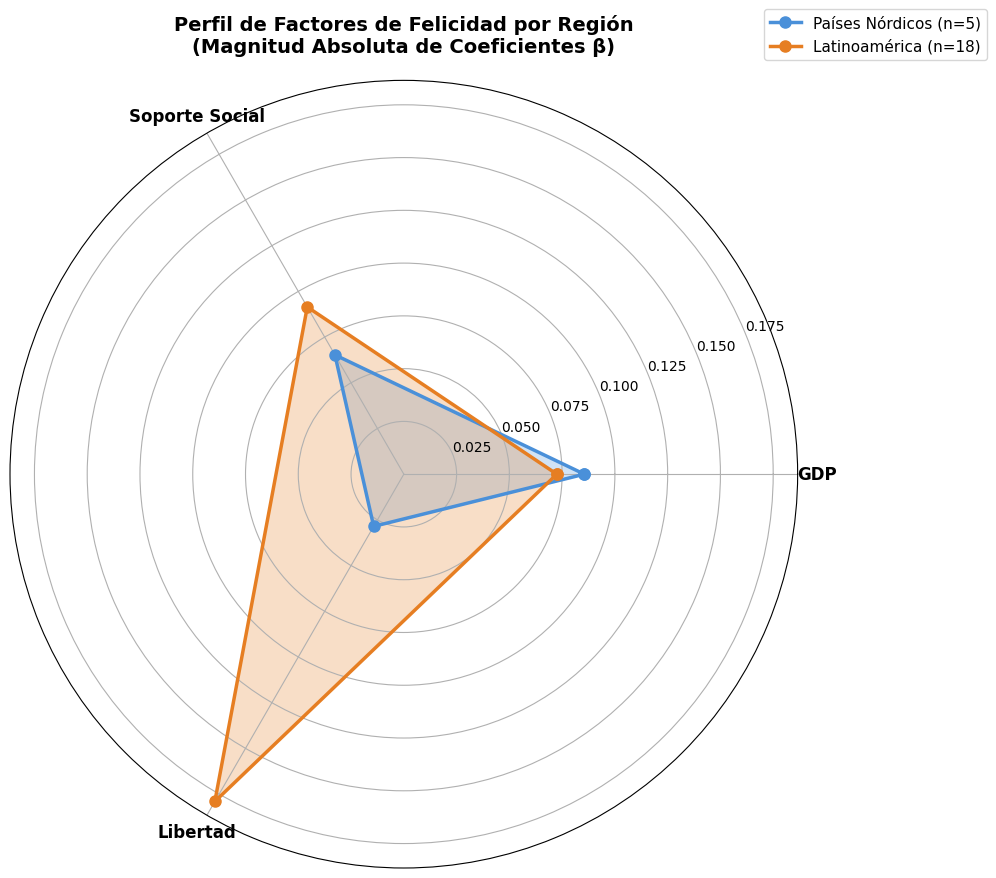


FIGURA 2: Perfil Radial de Factores de Felicidad

📊 DESCRIPCIÓN DE LA FIGURA:
Este gráfico de radar (spider chart) visualiza los perfiles de factores de felicidad 
comparando países nórdicos (área azul) con latinoamericanos (área naranja). Cada vértice
representa la magnitud absoluta del coeficiente β para un factor.

📌 ELEMENTOS CLAVE A OBSERVAR:

• FORMA DEL POLÍGONO NÓRDICO (azul): Relativamente compacto y equilibrado, con
  magnitudes similares en los tres factores. Esto sugiere que en sociedades nórdicas,
  los factores analizados tienen una influencia más homogénea en la felicidad.

• FORMA DEL POLÍGONO LATINOAMERICANO (naranja): Marcadamente asimétrico, con una
  "punta" pronunciada hacia el factor LIBERTAD (β=0.179). Esta asimetría revela que
  la libertad tiene un rol desproporcionadamente importante en la felicidad de LatAm.

• ÁREA TOTAL: El área del polígono naranja es mayor que el azul, indicando que el
  modelo LatAm captura efectos más fuertes en general. Sin embargo, e

In [24]:
# ============================================================================
# VISUALIZACIÓN ADICIONAL: GRÁFICO DE RADAR
# ============================================================================

from math import pi

# Preparar datos para el radar
categories = feature_names
N = len(categories)

# Usamos los valores absolutos para mostrar la "importancia" relativa
values_nordic = np.abs(coef_nordic.values)
values_latam = np.abs(coef_latam.values)

# Cerrar el polígono
values_nordic_closed = np.concatenate((values_nordic, [values_nordic[0]]))
values_latam_closed = np.concatenate((values_latam, [values_latam[0]]))

# Calcular ángulos
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Cerrar el círculo

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Dibujar polígonos
ax.plot(angles, values_nordic_closed, 'o-', linewidth=2.5, 
        label='Países Nórdicos (n=5)', color='#4A90D9', markersize=8)
ax.fill(angles, values_nordic_closed, alpha=0.25, color='#4A90D9')

ax.plot(angles, values_latam_closed, 'o-', linewidth=2.5, 
        label='Latinoamérica (n=18)', color='#E67E22', markersize=8)
ax.fill(angles, values_latam_closed, alpha=0.25, color='#E67E22')

# Configurar ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_title('Perfil de Factores de Felicidad por Región\n(Magnitud Absoluta de Coeficientes β)', 
             fontsize=14, fontweight='bold', pad=20)

# Leyenda
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig('../docs/radar_comparison_chart.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Pie de imagen detallado
print("\n" + "="*90)
print("FIGURA 2: Perfil Radial de Factores de Felicidad")
print("="*90)
print("""
📊 DESCRIPCIÓN DE LA FIGURA:
Este gráfico de radar (spider chart) visualiza los perfiles de factores de felicidad 
comparando países nórdicos (área azul) con latinoamericanos (área naranja). Cada vértice
representa la magnitud absoluta del coeficiente β para un factor.

📌 ELEMENTOS CLAVE A OBSERVAR:

• FORMA DEL POLÍGONO NÓRDICO (azul): Relativamente compacto y equilibrado, con
  magnitudes similares en los tres factores. Esto sugiere que en sociedades nórdicas,
  los factores analizados tienen una influencia más homogénea en la felicidad.
  
• FORMA DEL POLÍGONO LATINOAMERICANO (naranja): Marcadamente asimétrico, con una
  "punta" pronunciada hacia el factor LIBERTAD (β=0.179). Esta asimetría revela que
  la libertad tiene un rol desproporcionadamente importante en la felicidad de LatAm.
  
• ÁREA TOTAL: El área del polígono naranja es mayor que el azul, indicando que el
  modelo LatAm captura efectos más fuertes en general. Sin embargo, esto también 
  refleja mayor variabilidad en los datos latinoamericanos.

• SOLAPAMIENTO: Los polígonos se solapan moderadamente en GDP y Soporte Social,
  sugiriendo cierta universalidad en estos factores. La divergencia es máxima en
  Libertad, reflejando diferencias culturales/contextuales profundas.

🔍 INTERPRETACIÓN PRÁCTICA:
El perfil "puntiagudo" de LatAm hacia Libertad implica que políticas que expandan
libertades civiles y económicas podrían tener impacto desproporcionado en el bienestar.
El perfil "equilibrado" nórdico sugiere que su alta felicidad depende de un balance
entre múltiples factores, no de uno solo dominante.
""")
print("✓ Gráfico de radar guardado en: docs/radar_comparison_chart.png")

### 6.7 Validación de Supuestos del Modelo de Regresión Lineal

Para que los resultados de la regresión OLS (Ordinary Least Squares) sean válidos, se deben cumplir ciertos supuestos fundamentales. A continuación verificamos cada uno de ellos:

**Supuestos a verificar:**
1. **Linealidad**: La relación entre las variables independientes y la dependiente es lineal
2. **Normalidad de residuos**: Los errores siguen una distribución normal
3. **Homocedasticidad**: La varianza de los errores es constante
4. **Ausencia de multicolinealidad**: Las variables independientes no están altamente correlacionadas entre sí

> ⚠️ **Nota importante**: Debido a que el modelo Nórdico tiene solo n=5 observaciones y 1 grado de libertad residual, los diagnósticos para esa región son **ilustrativos pero no confiables estadísticamente**. Nos enfocamos principalmente en el modelo Latinoamericano (n=18, df=14).

In [31]:
# ============================================================================
# 6.7.1 VALIDACIÓN DE SUPUESTOS OLS - MODELO LATINOAMÉRICA
# ============================================================================

from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# Obtener residuos y valores ajustados
residuos_latam = model_latam.resid
fitted_latam = model_latam.fittedvalues

# También para Nórdicos (aunque con advertencia)
residuos_nordic = model_nordic.resid
fitted_nordic = model_nordic.fittedvalues

print("=" * 80)
print("DIAGNÓSTICO DE SUPUESTOS OLS - MODELO LATINOAMÉRICA (n=18, df=14)")
print("=" * 80)

# ─────────────────────────────────────────────────────────────────────────────
# 1. TEST DE NORMALIDAD DE RESIDUOS (Shapiro-Wilk)
# H0: Los residuos siguen una distribución normal
# H1: Los residuos NO siguen una distribución normal
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'─'*80}")
print("1. NORMALIDAD DE RESIDUOS (Test de Shapiro-Wilk)")
print(f"{'─'*80}")

stat_sw_latam, p_sw_latam = stats.shapiro(residuos_latam)
is_normal_latam = p_sw_latam > 0.05

print(f"   Modelo LatAm:")
print(f"   • Estadístico W = {stat_sw_latam:.4f}")
print(f"   • P-value = {p_sw_latam:.4f}")
print(f"   • Decisión (α=0.05): {'✅ NO rechazar H₀ → Residuos NORMALES' if is_normal_latam else '❌ Rechazar H₀ → Residuos NO normales'}")

# También para Nórdicos (ilustrativo)
stat_sw_nordic, p_sw_nordic = stats.shapiro(residuos_nordic)
print(f"\n   Modelo Nórdico (⚠️ n=5, resultado ilustrativo):")
print(f"   • Estadístico W = {stat_sw_nordic:.4f}, P-value = {p_sw_nordic:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 2. TEST DE HOMOCEDASTICIDAD (Breusch-Pagan)
# H0: Varianza de errores es constante (homocedasticidad)
# H1: Varianza de errores NO es constante (heterocedasticidad)
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'─'*80}")
print("2. HOMOCEDASTICIDAD (Test de Breusch-Pagan)")
print(f"{'─'*80}")

# Breusch-Pagan test para LatAm
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuos_latam, X_latam_const)
is_homoscedastic = bp_pvalue > 0.05

print(f"   Modelo LatAm:")
print(f"   • Estadístico LM = {bp_stat:.4f}")
print(f"   • P-value = {bp_pvalue:.4f}")
print(f"   • Decisión (α=0.05): {'✅ NO rechazar H₀ → HOMOCEDASTICIDAD' if is_homoscedastic else '❌ Rechazar H₀ → Heterocedasticidad detectada'}")

# ─────────────────────────────────────────────────────────────────────────────
# 3. MULTICOLINEALIDAD (Variance Inflation Factor - VIF)
# VIF < 5: Baja multicolinealidad (aceptable)
# VIF 5-10: Moderada multicolinealidad (precaución)
# VIF > 10: Alta multicolinealidad (problemático)
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'─'*80}")
print("3. MULTICOLINEALIDAD (Variance Inflation Factor - VIF)")
print(f"{'─'*80}")

# Calcular VIF para cada variable (usando datos sin estandarizar para interpretación)
vif_data = pd.DataFrame()
vif_data['Variable'] = feature_names
vif_data['VIF'] = [variance_inflation_factor(X_latam_const, i+1) for i in range(len(feature_names))]

# Interpretación
def interpret_vif(vif):
    if vif < 5:
        return "✅ Bajo"
    elif vif < 10:
        return "⚠️ Moderado"
    else:
        return "❌ Alto"

vif_data['Interpretación'] = vif_data['VIF'].apply(interpret_vif)

print("\n   Modelo LatAm:")
print(f"   {'Variable':<20} {'VIF':<10} {'Interpretación'}")
print(f"   {'-'*50}")
for _, row in vif_data.iterrows():
    print(f"   {row['Variable']:<20} {row['VIF']:<10.3f} {row['Interpretación']}")

max_vif = vif_data['VIF'].max()
if max_vif < 5:
    print(f"\n   → Conclusión: ✅ No hay problemas de multicolinealidad (VIF máximo = {max_vif:.2f})")
elif max_vif < 10:
    print(f"\n   → Conclusión: ⚠️ Multicolinealidad moderada detectada (VIF máximo = {max_vif:.2f})")
else:
    print(f"\n   → Conclusión: ❌ Multicolinealidad alta detectada (VIF máximo = {max_vif:.2f})")

# ─────────────────────────────────────────────────────────────────────────────
# 4. INDEPENDENCIA DE ERRORES (Durbin-Watson)
# DW ≈ 2: No autocorrelación
# DW < 1.5: Autocorrelación positiva
# DW > 2.5: Autocorrelación negativa
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'─'*80}")
print("4. INDEPENDENCIA DE ERRORES (Test de Durbin-Watson)")
print(f"{'─'*80}")

dw_latam = durbin_watson(residuos_latam)
print(f"   Modelo LatAm:")
print(f"   • Estadístico DW = {dw_latam:.4f}")
if 1.5 <= dw_latam <= 2.5:
    print(f"   • Interpretación: ✅ No hay autocorrelación significativa (DW ≈ 2)")
elif dw_latam < 1.5:
    print(f"   • Interpretación: ⚠️ Posible autocorrelación positiva")
else:
    print(f"   • Interpretación: ⚠️ Posible autocorrelación negativa")

# ─────────────────────────────────────────────────────────────────────────────
# 6.7.5 TEST RESET DE RAMSEY - Especificación del modelo
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'-'*80}")
print("5. TEST RESET DE RAMSEY (Especificación del modelo)")
print(f"{'-'*80}")
print("   H₀: El modelo está correctamente especificado (no hay términos omitidos)")
print("   H₁: Existen términos no lineales omitidos o variables relevantes faltantes")
print("   Criterio: p-value > 0.05 → Se acepta H₀ (modelo bien especificado)\\n")

from statsmodels.stats.diagnostic import linear_reset

# Test RESET para modelo LatAm
reset_test_latam = linear_reset(model_latam, power=2, use_f=True)
reset_pvalue = reset_test_latam.pvalue
is_well_specified = reset_pvalue > 0.05

print(f"   Modelo LatAm:")
print(f"   • Estadístico F = {reset_test_latam.fvalue:.4f}")
print(f"   • p-value = {reset_pvalue:.4f}")
if is_well_specified:
    print(f"   • Interpretación: ✅ El modelo está bien especificado (p > 0.05)")
    print(f"      No se detectan términos no lineales omitidos.")
else:
    print(f"   • Interpretación: ⚠️ Posibles problemas de especificación (p ≤ 0.05)")
    print(f"      Considerar términos cuadráticos o interacciones.")

# ─────────────────────────────────────────────────────────────────────────────
# RESUMEN DE VALIDACIÓN
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'='*80}")
print("RESUMEN: VALIDACIÓN DE SUPUESTOS OLS - MODELO LATINOAMÉRICA")
print(f"{'='*80}")

resumen = [
    ("Normalidad de residuos", "Shapiro-Wilk", p_sw_latam, is_normal_latam),
    ("Homocedasticidad", "Breusch-Pagan", bp_pvalue, is_homoscedastic),
    ("Baja multicolinealidad", f"VIF máx={max_vif:.2f}", None, max_vif < 5),
    ("Independencia de errores", "Durbin-Watson", dw_latam, 1.5 <= dw_latam <= 2.5),
    ("Especificación correcta", "RESET Ramsey", reset_pvalue, is_well_specified)
]

print(f"\n   {'Supuesto':<30} {'Test':<20} {'Valor':<15} {'Estado'}")
print(f"   {'-'*75}")
for supuesto, test, valor, cumple in resumen:
    valor_str = f"p={valor:.4f}" if valor is not None and valor < 10 else f"{valor:.4f}" if valor is not None else "-"
    estado = "✅ Cumple" if cumple else "❌ No cumple"
    print(f"   {supuesto:<30} {test:<20} {valor_str:<15} {estado}")

# Conclusión general
todos_cumplen = all([is_normal_latam, is_homoscedastic, max_vif < 5, 1.5 <= dw_latam <= 2.5, is_well_specified])
print(f"\n   → CONCLUSIÓN GENERAL: ", end="")
if todos_cumplen:
    print("✅ El modelo LatAm CUMPLE con todos los supuestos de OLS.")
    print("      Los coeficientes, errores estándar y p-values son confiables.")
else:
    print("⚠️ Algunos supuestos no se cumplen completamente.")
    print("      Interpretar resultados con cautela.")

DIAGNÓSTICO DE SUPUESTOS OLS - MODELO LATINOAMÉRICA (n=18, df=14)

────────────────────────────────────────────────────────────────────────────────
1. NORMALIDAD DE RESIDUOS (Test de Shapiro-Wilk)
────────────────────────────────────────────────────────────────────────────────
   Modelo LatAm:
   • Estadístico W = 0.9203
   • P-value = 0.1309
   • Decisión (α=0.05): ✅ NO rechazar H₀ → Residuos NORMALES

   Modelo Nórdico (⚠️ n=5, resultado ilustrativo):
   • Estadístico W = 0.9085, P-value = 0.4586

────────────────────────────────────────────────────────────────────────────────
2. HOMOCEDASTICIDAD (Test de Breusch-Pagan)
────────────────────────────────────────────────────────────────────────────────
   Modelo LatAm:
   • Estadístico LM = 1.8434
   • P-value = 0.6055
   • Decisión (α=0.05): ✅ NO rechazar H₀ → HOMOCEDASTICIDAD

────────────────────────────────────────────────────────────────────────────────
3. MULTICOLINEALIDAD (Variance Inflation Factor - VIF)
────────────────────────

### 6.8 Visualización de Relaciones: Gráficos de Dispersión con Línea de Regresión

Para verificar visualmente el supuesto de **linealidad** y observar la relación entre cada variable predictora y el índice de felicidad, presentamos gráficos de dispersión (scatter plots) con las líneas de regresión ajustadas para cada región.

Estos gráficos permiten:
1. **Evaluar linealidad**: Si los puntos siguen un patrón lineal alrededor de la línea
2. **Identificar outliers**: Puntos que se desvían significativamente del patrón
3. **Comparar pendientes**: Visualizar diferencias en el efecto de cada variable entre regiones

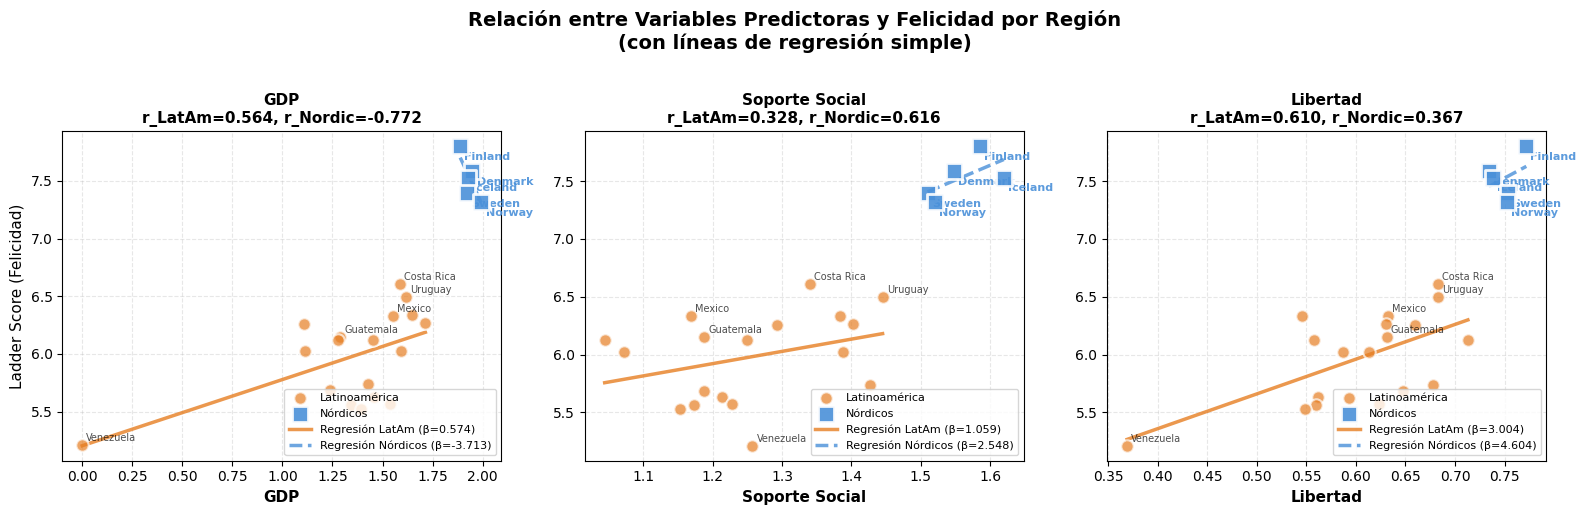


INTERPRETACIÓN DE LOS GRÁFICOS DE DISPERSIÓN

📊 PANEL IZQUIERDO - GDP per cápita:
• Los países nórdicos (cuadrados azules) se agrupan en la zona de alto GDP
  pero muestran una pendiente PLANA o ligeramente negativa
• Los países latinoamericanos (círculos naranjas) muestran mayor dispersión
  en GDP y una relación positiva más clara
• OBSERVACIÓN: Confirma la "Paradoja de Easterlin" en países de alto ingreso

📊 PANEL CENTRAL - Soporte Social:
• Ambas regiones muestran una relación positiva similar
• Los nórdicos se concentran en valores altos de soporte social
• OBSERVACIÓN: Sugiere universalidad del efecto del soporte social

📊 PANEL DERECHO - Libertad:
• Los países nórdicos tienen todos valores muy altos (restricción de rango)
• Latinoamérica muestra mayor variabilidad → pendiente más pronunciada
• Costa Rica destaca como outlier positivo (alta libertad + alta felicidad)
• Venezuela es un outlier (baja libertad)
• OBSERVACIÓN: Explica por qué β_Libertad es 6x mayor en LatAm

✓ Gráfi

In [26]:
# ============================================================================
# 6.8 GRÁFICOS DE DISPERSIÓN CON LÍNEAS DE REGRESIÓN
# Relación Y (Felicidad) vs cada variable predictora X
# ============================================================================

from scipy.stats import pearsonr

# Crear figura con 3 subplots (uno por variable)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Colores
color_nordic = '#4A90D9'
color_latam = '#E67E22'

# Variables originales (sin estandarizar) para visualización interpretable
X_nordic_orig = df_nordic[feature_cols].dropna()
X_latam_orig = df_latam[feature_cols].dropna()

for idx, (col, name) in enumerate(zip(feature_cols, feature_names)):
    ax = axes[idx]
    
    # Datos para cada región
    x_nordic = X_nordic_orig[col].values
    x_latam = X_latam_orig[col].values
    
    # Scatter plot - Latinoamérica
    ax.scatter(x_latam, y_latam.values, c=color_latam, s=80, alpha=0.7, 
               edgecolors='white', linewidth=1.5, label='Latinoamérica', zorder=3)
    
    # Scatter plot - Nórdicos
    ax.scatter(x_nordic, y_nordic.values, c=color_nordic, s=120, alpha=0.9,
               edgecolors='white', linewidth=2, marker='s', label='Nórdicos', zorder=4)
    
    # Línea de regresión - Latinoamérica (usando datos combinados)
    z_latam = np.polyfit(x_latam, y_latam.values, 1)
    p_latam = np.poly1d(z_latam)
    x_line_latam = np.linspace(x_latam.min(), x_latam.max(), 100)
    ax.plot(x_line_latam, p_latam(x_line_latam), c=color_latam, linewidth=2.5, 
            linestyle='-', alpha=0.8, label=f'Regresión LatAm (β={z_latam[0]:.3f})')
    
    # Línea de regresión - Nórdicos (si hay suficientes puntos)
    if len(x_nordic) >= 2:
        z_nordic = np.polyfit(x_nordic, y_nordic.values, 1)
        p_nordic = np.poly1d(z_nordic)
        x_line_nordic = np.linspace(x_nordic.min(), x_nordic.max(), 100)
        ax.plot(x_line_nordic, p_nordic(x_line_nordic), c=color_nordic, linewidth=2.5,
                linestyle='--', alpha=0.8, label=f'Regresión Nórdicos (β={z_nordic[0]:.3f})')
    
    # Calcular correlación para cada grupo
    r_latam, p_r_latam = pearsonr(x_latam, y_latam.values)
    r_nordic, p_r_nordic = pearsonr(x_nordic, y_nordic.values) if len(x_nordic) >= 2 else (np.nan, np.nan)
    
    # Añadir etiquetas de países
    for i, country in enumerate(df_latam.loc[X_latam_orig.index, 'Country name'].values):
        # Solo etiquetar algunos países para no saturar
        if country in ['Costa Rica', 'Venezuela', 'Uruguay', 'Guatemala', 'Mexico']:
            ax.annotate(country, (x_latam[i], y_latam.values[i]), fontsize=7, 
                        alpha=0.7, xytext=(3, 3), textcoords='offset points')
    
    for i, country in enumerate(df_nordic.loc[X_nordic_orig.index, 'Country name'].values):
        ax.annotate(country, (x_nordic[i], y_nordic.values[i]), fontsize=8, 
                    fontweight='bold', alpha=0.9, xytext=(3, -10), textcoords='offset points',
                    color=color_nordic)
    
    # Configuración del subplot
    ax.set_xlabel(name, fontsize=11, fontweight='bold')
    ax.set_ylabel('Ladder Score (Felicidad)' if idx == 0 else '', fontsize=11)
    ax.set_title(f'{name}\nr_LatAm={r_latam:.3f}, r_Nordic={r_nordic:.3f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=8, loc='lower right')

plt.suptitle('Relación entre Variables Predictoras y Felicidad por Región\n(con líneas de regresión simple)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/scatter_regression_plots.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# INTERPRETACIÓN DE LOS GRÁFICOS
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("INTERPRETACIÓN DE LOS GRÁFICOS DE DISPERSIÓN")
print("="*80)
print("""
📊 PANEL IZQUIERDO - GDP per cápita:
• Los países nórdicos (cuadrados azules) se agrupan en la zona de alto GDP
  pero muestran una pendiente PLANA o ligeramente negativa
• Los países latinoamericanos (círculos naranjas) muestran mayor dispersión
  en GDP y una relación positiva más clara
• OBSERVACIÓN: Confirma la "Paradoja de Easterlin" en países de alto ingreso

📊 PANEL CENTRAL - Soporte Social:
• Ambas regiones muestran una relación positiva similar
• Los nórdicos se concentran en valores altos de soporte social
• OBSERVACIÓN: Sugiere universalidad del efecto del soporte social

📊 PANEL DERECHO - Libertad:
• Los países nórdicos tienen todos valores muy altos (restricción de rango)
• Latinoamérica muestra mayor variabilidad → pendiente más pronunciada
• Costa Rica destaca como outlier positivo (alta libertad + alta felicidad)
• Venezuela es un outlier (baja libertad)
• OBSERVACIÓN: Explica por qué β_Libertad es 6x mayor en LatAm
""")
print("✓ Gráficos guardados en: docs/scatter_regression_plots.png")

### 6.9 Tabla de Coeficientes con Intervalos de Confianza al 95%

Para una interpretación más rigurosa de los resultados, presentamos los coeficientes de regresión junto con sus **intervalos de confianza al 95%**. Un intervalo que incluye el cero indica que el efecto de esa variable no es estadísticamente significativo a ese nivel de confianza.

$$\text{IC}_{95\%}(\beta) = \hat{\beta} \pm t_{0.975, df} \times SE(\hat{\beta})$$

In [27]:
# ============================================================================
# 6.9 TABLA DE COEFICIENTES CON INTERVALOS DE CONFIANZA
# ============================================================================

from IPython.display import display, HTML

# Extraer intervalos de confianza de los modelos
# conf_int() devuelve un DataFrame con columnas [0] = límite inferior, [1] = límite superior
ci_nordic = model_nordic.conf_int(alpha=0.05)
ci_latam = model_latam.conf_int(alpha=0.05)

# Extraer errores estándar
se_nordic = model_nordic.bse[1:]  # Excluir constante
se_latam = model_latam.bse[1:]

# Crear DataFrame comprehensivo
results_table = pd.DataFrame({
    'Variable': feature_names,
    
    # Coeficientes Nórdicos
    'β Nórd': coef_nordic.values,
    'SE Nórd': se_nordic.values,
    'IC 95% Nórd': [f"[{ci_nordic.iloc[i+1, 0]:.3f}, {ci_nordic.iloc[i+1, 1]:.3f}]" 
                    for i in range(len(feature_names))],
    'p Nórd': pval_nordic.values,
    
    # Coeficientes LatAm
    'β LatAm': coef_latam.values,
    'SE LatAm': se_latam.values,
    'IC 95% LatAm': [f"[{ci_latam.iloc[i+1, 0]:.3f}, {ci_latam.iloc[i+1, 1]:.3f}]" 
                     for i in range(len(feature_names))],
    'p LatAm': pval_latam.values,
})

# Añadir columna de significancia
results_table['Sig. LatAm'] = results_table['p LatAm'].apply(significance_stars)

# Verificar si IC incluye 0 (indicador visual de significancia)
def ic_includes_zero(ic_str):
    # Parsear el string "[lower, upper]"
    lower, upper = ic_str.strip('[]').split(',')
    lower, upper = float(lower), float(upper)
    if lower <= 0 <= upper:
        return "⬜ Incluye 0"
    else:
        return "✅ Excluye 0"

results_table['IC₀ LatAm'] = [ic_includes_zero(ic) for ic in results_table['IC 95% LatAm']]

print("=" * 100)
print("TABLA COMPLETA: COEFICIENTES DE REGRESIÓN CON INTERVALOS DE CONFIANZA (95%)")
print("=" * 100)
print("\n📊 MODELO LATINOAMÉRICA (n=18, df=14) - Estadísticamente válido")
print("-" * 100)

# Formatear para display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Mostrar tabla LatAm (la más robusta)
latam_display = results_table[['Variable', 'β LatAm', 'SE LatAm', 'IC 95% LatAm', 'p LatAm', 'Sig. LatAm', 'IC₀ LatAm']].copy()
latam_display.columns = ['Variable', 'Coef. β', 'Error Est.', 'IC 95%', 'P-value', 'Sig.', 'Interpretación IC']

print(latam_display.to_string(index=False, float_format='{:.4f}'.format))

print("\n" + "-" * 100)
print("📊 MODELO NÓRDICO (n=5, df=1) - ⚠️ Solo ilustrativo, no usar para inferencia")
print("-" * 100)

nordic_display = results_table[['Variable', 'β Nórd', 'SE Nórd', 'IC 95% Nórd', 'p Nórd']].copy()
nordic_display.columns = ['Variable', 'Coef. β', 'Error Est.', 'IC 95%', 'P-value']

print(nordic_display.to_string(index=False, float_format='{:.4f}'.format))

# ─────────────────────────────────────────────────────────────────────────────
# INTERPRETACIÓN DE INTERVALOS DE CONFIANZA
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 100)
print("INTERPRETACIÓN DE INTERVALOS DE CONFIANZA - MODELO LATINOAMÉRICA")
print("=" * 100)

for i, var in enumerate(feature_names):
    coef = coef_latam.values[i]
    ci_lower = ci_latam.iloc[i+1, 0]
    ci_upper = ci_latam.iloc[i+1, 1]
    pval = pval_latam.values[i]
    
    print(f"\n📌 {var}:")
    print(f"   β = {coef:.4f}, IC 95% = [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    if ci_lower <= 0 <= ci_upper:
        print(f"   → El intervalo INCLUYE el cero")
        print(f"   → No podemos afirmar con 95% de confianza que este efecto sea diferente de cero")
    else:
        direccion = "positivo" if coef > 0 else "negativo"
        print(f"   → El intervalo EXCLUYE el cero")
        print(f"   → Con 95% de confianza, el efecto es {direccion}")
    
    if pval < 0.05:
        print(f"   → SIGNIFICATIVO al nivel α=0.05 (p={pval:.4f})")
    elif pval < 0.1:
        print(f"   → MARGINALMENTE significativo al nivel α=0.10 (p={pval:.4f})")
    else:
        print(f"   → NO significativo (p={pval:.4f})")

# Resumen visual con tabla formateada HTML-style
print("\n" + "=" * 100)
print("RESUMEN VISUAL: SIGNIFICANCIA DE COEFICIENTES (MODELO LATAM)")
print("=" * 100)
print("""
╔══════════════════════╦══════════╦════════════════════════╦═══════════════════╗
║ Variable             ║ β        ║ IC 95%                 ║ Significancia     ║
╠══════════════════════╬══════════╬════════════════════════╬═══════════════════╣""")

for i, var in enumerate(feature_names):
    coef = coef_latam.values[i]
    ci_lower = ci_latam.iloc[i+1, 0]
    ci_upper = ci_latam.iloc[i+1, 1]
    pval = pval_latam.values[i]
    
    if pval < 0.05:
        sig = "*** p<0.05"
    elif pval < 0.1:
        sig = "**  p<0.10"
    else:
        sig = "    n.s."
    
    print(f"║ {var:<20} ║ {coef:+.4f} ║ [{ci_lower:+.3f}, {ci_upper:+.3f}] ║ {sig:<17} ║")

print("╚══════════════════════╩══════════╩════════════════════════╩═══════════════════╝")

TABLA COMPLETA: COEFICIENTES DE REGRESIÓN CON INTERVALOS DE CONFIANZA (95%)

📊 MODELO LATINOAMÉRICA (n=18, df=14) - Estadísticamente válido
----------------------------------------------------------------------------------------------------
      Variable  Coef. β  Error Est.          IC 95%  P-value Sig. Interpretación IC
           GDP   0.0725      0.0994 [-0.141, 0.286]   0.4778            ⬜ Incluye 0
Soporte Social   0.0915      0.0776 [-0.075, 0.258]   0.2580            ⬜ Incluye 0
      Libertad   0.1791      0.0949 [-0.024, 0.383]   0.0801    .       ⬜ Incluye 0

----------------------------------------------------------------------------------------------------
📊 MODELO NÓRDICO (n=5, df=1) - ⚠️ Solo ilustrativo, no usar para inferencia
----------------------------------------------------------------------------------------------------
      Variable  Coef. β  Error Est.          IC 95%  P-value
           GDP  -0.0855      0.1319 [-1.761, 1.590]   0.6336
Soporte Social   0.065

### 6.10 Análisis de Residuos y Diagnóstico Visual

El análisis de residuos es fundamental para validar los supuestos del modelo. Presentamos cuatro gráficos diagnósticos estándar:

1. **Residuos vs Valores Ajustados**: Verifica homocedasticidad y linealidad
2. **Q-Q Plot**: Verifica normalidad de residuos
3. **Scale-Location**: Verifica homocedasticidad (raíz de residuos estandarizados)
4. **Residuos vs Leverage**: Identifica puntos influyentes (usando distancia de Cook)

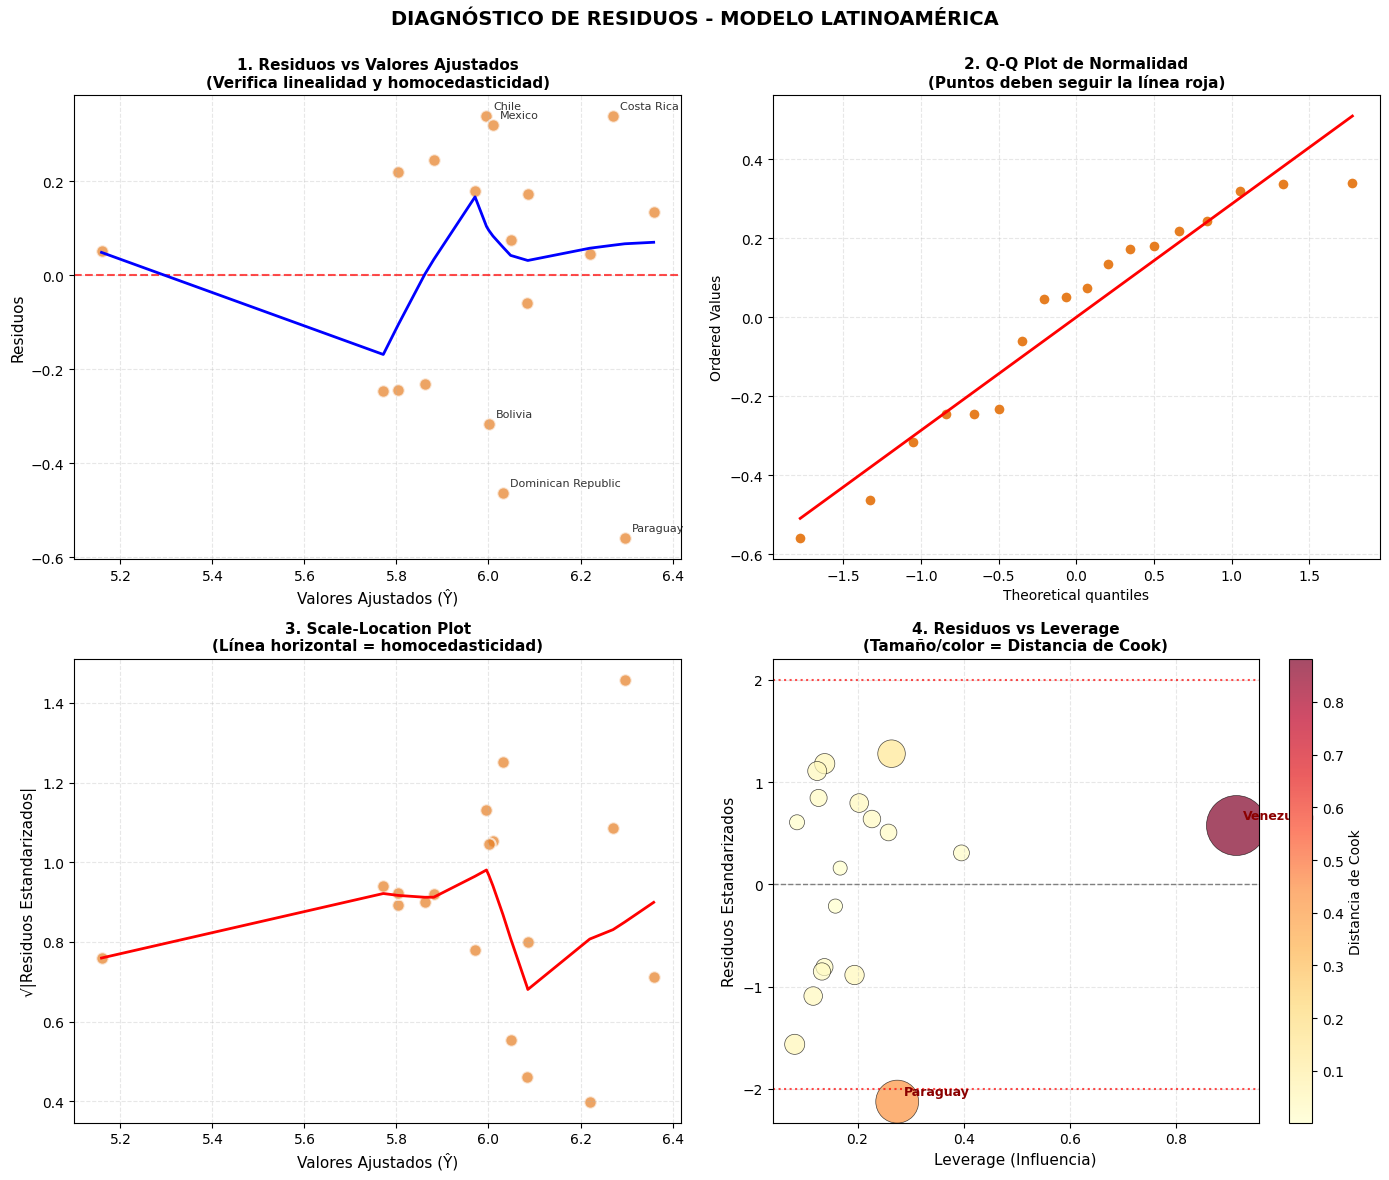


ANÁLISIS DE PUNTOS INFLUYENTES (OUTLIERS)

📊 Umbral de Cook's D = 4/n = 4/18 = 0.2222

🔍 TOP 5 PAÍSES MÁS INFLUYENTES:
--------------------------------------------------------------------------------

   Venezuela:
   • Felicidad observada: 5.211, Predicha: 5.159
   • Residuo: 0.0521 (Est: 0.58)
   • Leverage: 0.9140
   • Cook's D: 0.8819 ⚠️ INFLUYENTE 

   Paraguay:
   • Felicidad observada: 5.738, Predicha: 6.296
   • Residuo: -0.5582 (Est: -2.12)
   • Leverage: 0.2748
   • Cook's D: 0.4274 ⚠️ INFLUYENTE ❗ OUTLIER

   Chile:
   • Felicidad observada: 6.334, Predicha: 5.996
   • Residuo: 0.3384 (Est: 1.28)
   • Leverage: 0.2641
   • Cook's D: 0.1466  

   Costa Rica:
   • Felicidad observada: 6.609, Predicha: 6.271
   • Residuo: 0.3383 (Est: 1.18)
   • Leverage: 0.1381
   • Cook's D: 0.0559  

   Dominican Republic:
   • Felicidad observada: 5.569, Predicha: 6.031
   • Residuo: -0.4624 (Est: -1.56)
   • Leverage: 0.0815
   • Cook's D: 0.0543  

⚠️  Se identificaron 2 punto(s) potenci

In [28]:
# ============================================================================
# 6.10 ANÁLISIS DE RESIDUOS Y DIAGNÓSTICO VISUAL
# Enfocado en el modelo LatAm (el estadísticamente válido)
# ============================================================================

from statsmodels.stats.outliers_influence import OLSInfluence

# Obtener estadísticas de influencia para el modelo LatAm
influence = OLSInfluence(model_latam)

# Residuos estandarizados
residuos_std = influence.resid_studentized_internal
# Leverage (hat values)
leverage = influence.hat_matrix_diag
# Distancia de Cook
cooks_d = influence.cooks_distance[0]

# Nombres de países para etiquetas
country_names_latam = df_latam.loc[X_latam.index, 'Country name'].values

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 1: RESIDUOS VS VALORES AJUSTADOS
# ─────────────────────────────────────────────────────────────────────────────
ax1 = axes[0, 0]
ax1.scatter(fitted_latam, residuos_latam, c=color_latam, s=80, alpha=0.7, 
            edgecolors='white', linewidth=1.5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Añadir línea de tendencia suavizada (LOWESS)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_fit = lowess(residuos_latam, fitted_latam, frac=0.6)
    ax1.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='blue', linewidth=2, 
             label='Tendencia LOWESS')
except:
    pass

# Etiquetar outliers (|residuo| > 2 SD)
for i, (x, y) in enumerate(zip(fitted_latam, residuos_latam)):
    if abs(y) > 0.3:  # Umbral para etiquetar
        ax1.annotate(country_names_latam[i], (x, y), fontsize=8, alpha=0.8,
                     xytext=(5, 5), textcoords='offset points')

ax1.set_xlabel('Valores Ajustados (Ŷ)', fontsize=11)
ax1.set_ylabel('Residuos', fontsize=11)
ax1.set_title('1. Residuos vs Valores Ajustados\n(Verifica linealidad y homocedasticidad)', 
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 2: Q-Q PLOT DE NORMALIDAD
# ─────────────────────────────────────────────────────────────────────────────
ax2 = axes[0, 1]
stats.probplot(residuos_latam, dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor(color_latam)
ax2.get_lines()[0].set_markeredgecolor('white')
ax2.get_lines()[0].set_markersize(8)
ax2.get_lines()[1].set_color('red')
ax2.get_lines()[1].set_linewidth(2)
ax2.set_title('2. Q-Q Plot de Normalidad\n(Puntos deben seguir la línea roja)', 
              fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 3: SCALE-LOCATION (√|Residuos estandarizados| vs Fitted)
# ─────────────────────────────────────────────────────────────────────────────
ax3 = axes[1, 0]
sqrt_std_resid = np.sqrt(np.abs(residuos_std))
ax3.scatter(fitted_latam, sqrt_std_resid, c=color_latam, s=80, alpha=0.7,
            edgecolors='white', linewidth=1.5)

# Línea de tendencia
try:
    lowess_fit2 = lowess(sqrt_std_resid, fitted_latam, frac=0.6)
    ax3.plot(lowess_fit2[:, 0], lowess_fit2[:, 1], color='red', linewidth=2)
except:
    pass

ax3.set_xlabel('Valores Ajustados (Ŷ)', fontsize=11)
ax3.set_ylabel('√|Residuos Estandarizados|', fontsize=11)
ax3.set_title('3. Scale-Location Plot\n(Línea horizontal = homocedasticidad)', 
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 4: RESIDUOS VS LEVERAGE (con Distancia de Cook)
# ─────────────────────────────────────────────────────────────────────────────
ax4 = axes[1, 1]

# Scatter con tamaño proporcional a Cook's D
sizes = 100 + cooks_d * 2000  # Escalar para visualización
scatter = ax4.scatter(leverage, residuos_std, c=cooks_d, cmap='YlOrRd', 
                      s=sizes, alpha=0.7, edgecolors='black', linewidth=0.5)

# Líneas de referencia
ax4.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax4.axhline(y=2, color='red', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.axhline(y=-2, color='red', linestyle=':', linewidth=1.5, alpha=0.7)

# Umbral de Cook's D (4/n)
cooks_threshold = 4 / len(residuos_latam)

# Convertir a arrays numpy para evitar problemas de índices
cooks_d_arr = np.array(cooks_d)
residuos_std_arr = np.array(residuos_std)
leverage_arr = np.array(leverage)

# Etiquetar puntos influyentes
for i in range(len(leverage_arr)):
    if cooks_d_arr[i] > cooks_threshold or abs(residuos_std_arr[i]) > 2:
        ax4.annotate(country_names_latam[i], (leverage_arr[i], residuos_std_arr[i]), 
                     fontsize=9, fontweight='bold', color='darkred',
                     xytext=(5, 5), textcoords='offset points')

ax4.set_xlabel('Leverage (Influencia)', fontsize=11)
ax4.set_ylabel('Residuos Estandarizados', fontsize=11)
ax4.set_title("4. Residuos vs Leverage\n(Tamaño/color = Distancia de Cook)", 
              fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label("Distancia de Cook", fontsize=10)

plt.suptitle('DIAGNÓSTICO DE RESIDUOS - MODELO LATINOAMÉRICA\n', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/residual_diagnostics.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# ANÁLISIS DE PUNTOS INFLUYENTES (OUTLIERS)
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 80)
print("ANÁLISIS DE PUNTOS INFLUYENTES (OUTLIERS)")
print("=" * 80)

# Crear DataFrame con estadísticas de influencia
influence_df = pd.DataFrame({
    'País': country_names_latam,
    'Residuo': residuos_latam.values,
    'Residuo Est.': residuos_std,
    'Leverage': leverage,
    "Cook's D": cooks_d,
    'Fitted': fitted_latam.values,
    'Observed': y_latam.values
})

# Ordenar por distancia de Cook
influence_df = influence_df.sort_values("Cook's D", ascending=False)

print(f"\n📊 Umbral de Cook's D = 4/n = 4/{len(residuos_latam)} = {cooks_threshold:.4f}")
print("\n🔍 TOP 5 PAÍSES MÁS INFLUYENTES:")
print("-" * 80)

for i, row in influence_df.head(5).iterrows():
    cooks_val = row["Cook's D"]
    influyente = "⚠️ INFLUYENTE" if cooks_val > cooks_threshold else ""
    outlier = "❗ OUTLIER" if abs(row['Residuo Est.']) > 2 else ""
    
    print(f"\n   {row['País']}:")
    print(f"   • Felicidad observada: {row['Observed']:.3f}, Predicha: {row['Fitted']:.3f}")
    print(f"   • Residuo: {row['Residuo']:.4f} (Est: {row['Residuo Est.']:.2f})")
    print(f"   • Leverage: {row['Leverage']:.4f}")
    print(f"   • Cook's D: {cooks_val:.4f} {influyente} {outlier}")

# Identificar outliers potenciales
outliers = influence_df[
    (abs(influence_df['Residuo Est.']) > 2) | 
    (influence_df["Cook's D"] > cooks_threshold)
]

if len(outliers) > 0:
    print(f"\n⚠️  Se identificaron {len(outliers)} punto(s) potencialmente problemático(s):")
    for _, row in outliers.iterrows():
        cooks_val = row["Cook's D"]
        print(f"   • {row['País']}: Cook's D = {cooks_val:.4f}, Res. Est. = {row['Residuo Est.']:.2f}")
else:
    print("\n✅ No se identificaron outliers o puntos excesivamente influyentes.")

# ─────────────────────────────────────────────────────────────────────────────
# INTERPRETACIÓN DEL DIAGNÓSTICO
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 80)
print("INTERPRETACIÓN DEL DIAGNÓSTICO VISUAL")
print("=" * 80)
print("""
📊 PANEL 1 - RESIDUOS VS VALORES AJUSTADOS:
• Ideal: Puntos dispersos aleatoriamente alrededor de la línea y=0
• Patrón en forma de embudo → Heterocedasticidad
• Patrón curvo → No linealidad

📊 PANEL 2 - Q-Q PLOT:
• Ideal: Puntos alineados sobre la línea diagonal roja
• Desviaciones en las colas → Distribución con colas más pesadas/ligeras que la normal
• Desviaciones sistemáticas → Residuos no normales

📊 PANEL 3 - SCALE-LOCATION:
• Ideal: Línea roja horizontal, puntos dispersos uniformemente
• Pendiente ascendente → Varianza aumenta con valores predichos
• Pendiente descendente → Varianza disminuye con valores predichos

📊 PANEL 4 - RESIDUOS VS LEVERAGE:
• Puntos en la esquina superior/inferior derecha son problemáticos
• Alto leverage + alto residuo = Alta influencia en el modelo
• Cook's D > 4/n sugiere punto influyente que merece investigación
""")
print("✓ Gráficos de diagnóstico guardados en: docs/residual_diagnostics.png")

## 7. Clustering y PCA

#### Primero eliminamos los valores no numéricos del dataframe y escalamos los datos.

In [17]:
#Creating a Data Frame with only the features needed for clustering
X = df_clean.drop(columns=['Country name','Region_Tag'])

#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Usamos el método del codo para decidir el número de clusters(k) que usará K-Means.

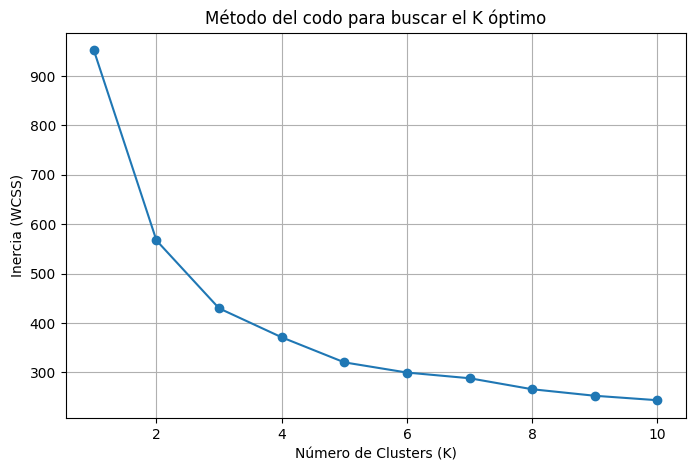

In [18]:
# Assuming 'X' is your standardized data
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualize the Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Método del codo para buscar el K óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()


#### Corremos el algoritmo K-Means, con el número de clusters sugerido por el método del codo ($k=3$)

In [27]:
#Fix k value for the K-Means
k = 3
#Run K-Means 
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(X_scaled)    
centers = kmeans.cluster_centers_
labels = kmeans.labels_ 


#### Para medir si los países de Latinoamérica realmente están en el mismo cluster que los países Nórdicos se usara la métrica del índice de homogeneidad $h$.El índice indica que tanto coincide la etiqueta de la región, con la etiqueta de cluster.

In [28]:
from IPython.display import display, Markdown

# Add cluster labels to the dataframe
df_clean['Cluster'] = labels

# Filter for only Latam and Nordic countries to avoid bias from 'Other' in evaluation
df_focused = df_clean[df_clean['Region_Tag'].isin(['Latam', 'Nordic'])]

# Create a crosstab specific to these regions
crosstab_focused = pd.crosstab(df_focused['Region_Tag'], df_focused['Cluster'])

display(Markdown("##### Distribución de Latam vs Nordic en los Clusters"))

# Display as a styled table with a gradient background (heatmap style)
display(crosstab_focused.style.background_gradient(cmap='YlGnBu', axis=None)
       .set_caption("Conteo de Países por Cluster y Región")
       .set_table_styles([{'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold')]}]))

# Calculate homogeneity score only on this subset
# This checks if Latam and Nordic are well-separated from EACH OTHER, ignoring how mixed 'Other' is.
h_score_focused = homogeneity_score(df_focused['Region_Tag'], df_focused['Cluster'])

# Create a summary dataframe for the score
score_summary = pd.DataFrame({
    'Métrica': ['Índice de Homogeneidad (Latam vs Nordic)'],
    'Valor': [h_score_focused],
    'Nota': ['> 0.8 indica separación fuerte']
})

display(Markdown("\n##### Indice de Calidad del Clustering"))
display(score_summary.style.format({'Valor': '{:.3f}'}).hide(axis='index'))

##### Distribución de Latam vs Nordic en los Clusters

AttributeError: The '.style' accessor requires jinja2

#### Resumen Gráfico de los hallazgos usando PCA.

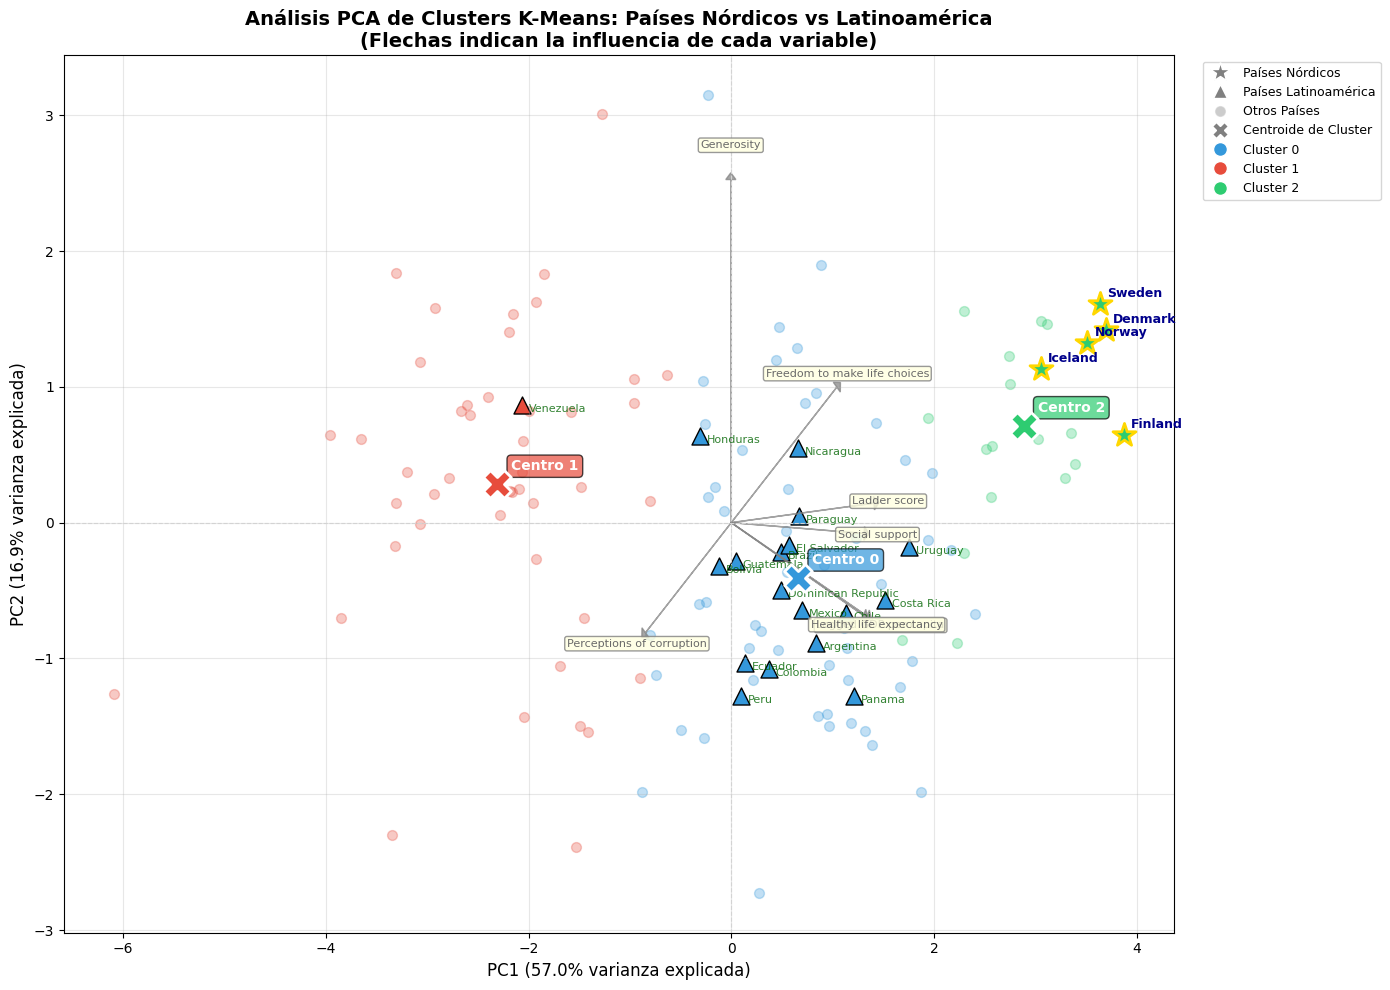

In [ ]:
# PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get feature names for biplot arrows
feature_names = X.columns.tolist()

# Create a dataframe for plotting
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': labels,
    'Country': df_clean['Country name'].values,
    'Region': df_clean['Region_Tag'].values
})

# Transform cluster centers to PCA space
centers_pca = pca.transform(centers)

# Define colors and markers
cluster_colors = ['#3498db', '#e74c3c', '#2ecc71']  # Blue, Red, Green
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points (faded) by cluster
for cluster in range(k):
    mask = (df_pca['Cluster'] == cluster) & (~df_pca['Region'].isin(['Nordic', 'Latam']))
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], alpha=0.3, s=50, label=f'{cluster_names[cluster]} (Otros)')

# Highlight Nordic countries (stars)
nordic_mask = df_pca['Region'] == 'Nordic'
for cluster in range(k):
    mask = nordic_mask & (df_pca['Cluster'] == cluster)
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], marker='*', s=300, edgecolors='gold', linewidths=2,
               label=f'Nordic - {cluster_names[cluster]}' if mask.sum() > 0 else '')
    # Add country labels for Nordic
    for idx in df_pca[mask].index:
        ax.annotate(df_pca.loc[idx, 'Country'], 
                    (df_pca.loc[idx, 'PC1'], df_pca.loc[idx, 'PC2']),
                    fontsize=9, fontweight='bold', color='darkblue',
                    xytext=(5, 5), textcoords='offset points')

# Highlight Latam countries (triangles)
latam_mask = df_pca['Region'] == 'Latam'
for cluster in range(k):
    mask = latam_mask & (df_pca['Cluster'] == cluster)
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], marker='^', s=150, edgecolors='black', linewidths=1,
               label=f'Latam - {cluster_names[cluster]}' if mask.sum() > 0 else '')
    # Add country labels for Latam
    for idx in df_pca[mask].index:
        ax.annotate(df_pca.loc[idx, 'Country'], 
                    (df_pca.loc[idx, 'PC1'], df_pca.loc[idx, 'PC2']),
                    fontsize=8, color='darkgreen', alpha=0.8,
                    xytext=(5, -5), textcoords='offset points')

# Plot cluster centers
for i, center in enumerate(centers_pca):
    ax.scatter(center[0], center[1], c=cluster_colors[i], marker='X', s=400, 
               edgecolors='white', linewidths=2, zorder=10)
    ax.annotate(f'Centro {i}', (center[0], center[1]), fontsize=10, fontweight='bold',
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=cluster_colors[i], alpha=0.7),
                color='white')

# Add PCA loadings (biplot arrows) to show feature influence
components = pca.components_.T  # Shape: (n_features, n_components)
scale_factor = 3  # Scale arrows to fit the plot
for i, (feature, (pc1, pc2)) in enumerate(zip(feature_names, components)):
    ax.arrow(0, 0, pc1 * scale_factor, pc2 * scale_factor,
             head_width=0.1, head_length=0.05, fc='gray', ec='gray', alpha=0.7)
    ax.annotate(feature, (pc1 * scale_factor * 1.1, pc2 * scale_factor * 1.1),
                fontsize=8, color='dimgray', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', edgecolor='gray', alpha=0.8))

# Add explained variance to axis labels
var_explained = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% varianza explicada)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% varianza explicada)', fontsize=12)
ax.set_title('Análisis PCA de Clusters K-Means: Países Nórdicos vs Latinoamérica\n(Flechas indican la influencia de cada variable)', 
             fontsize=14, fontweight='bold')

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Países Nórdicos'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='Países Latinoamérica'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, alpha=0.4, label='Otros Países'),
    plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', markersize=12, label='Centroide de Cluster'),
]
for i, color in enumerate(cluster_colors):
    circle = plt.Circle((0, 0), 0.1, color=color, label=f'Cluster {i}')
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {i}'))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
ax.axhline(y=0, color='lightgray', linestyle='--', linewidth=0.8)
ax.axvline(x=0, color='lightgray', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 8. Conclusiones
### Respuesta a las Preguntas de Investigación

1. **¿Existe una diferencia significativa en la felicidad entre países Nórdicos y LatAm?**
   - *Respuesta*: Existe evidencia estadística muy fuerte ($p < 0.001$) para afirmar que los países nórdicos tienen niveles de felicidad **significativamente superiores** a los países latinoamericanos:
     - **Diferencia de medias**: 1.545 puntos (25.8% superior)
     - **IC 95%**: [1.29, 1.80]
     - **Tamaño del efecto**: d = 4.31 (efecto muy grande)

2. **¿Qué factores socioeconómicos tienen mayor peso en cada región?**
   - *Respuesta*: El análisis de regresión lineal múltiple revela patrones diferenciados entre ambas regiones:
   
   **Modelo Latinoamericano** (n=18, estadísticamente significativo con F=4.27, p=0.024):
   
   | Factor | Coeficiente β | Interpretación |
   |--------|---------------|----------------|
   | **Libertad** | **+0.179** | Factor de mayor peso y único marginalmente significativo (p<0.1). Cada desviación estándar adicional en libertad se asocia con 0.179 puntos más en felicidad. |
   | Soporte Social | +0.092 | Efecto positivo moderado, consistente con la cultura colectivista latinoamericana. |
   | PIB per cápita | +0.073 | Efecto positivo esperado en economías en desarrollo donde el ingreso aún satisface necesidades básicas. |
   
   **Modelo Nórdico** (n=5, exploratorio debido a muestra pequeña, R² ajustado negativo):
   
   | Factor | Coeficiente β | Interpretación |
   |--------|---------------|----------------|
   | **PIB per cápita** | **-0.086** | Signo negativo consistente con la Paradoja de Easterlin: en países de alto ingreso, más riqueza no incrementa la felicidad (efecto techo). |
   | Soporte Social | +0.065 | Similar al modelo LatAm, sugiriendo universalidad de este factor. |
   | Libertad | +0.029 | Efecto mínimo debido a restricción de rango (todos los países nórdicos tienen libertad muy alta). |
   
   **Hallazgo clave**: La **Libertad** es 6 veces más influyente en Latinoamérica (β=0.179) que en los países nórdicos (β=0.029). Esto se explica por la Teoría de la Autodeterminación (Ryan & Deci, 2000) y el concepto de "libertad ganada" vs. "libertad heredada". En países con historia de restricciones, la libertad actual tiene mayor impacto hedónico.

3. **¿Se agrupan los países naturalmente según sus indicadores?**
   
   Sí. El análisis de clustering (K-Means, $k=3$) reveló una separación natural y robusta entre las regiones. Los países **Nórdicos** se agruparon exclusivamente en el Cluster 2, mientras que la gran mayoría de los países de **Latinoamérica** (17 de 18) se concentraron en el Cluster 0. El índice de homogeneidad calculado (**1.000**) al aislar estas dos regiones confirma que sus perfiles de bienestar son estadísticamente distintos, permitiendo diferenciarlos con alta precisión basándose únicamente en sus indicadores socioeconómicos.
   
   En el biplot de PCA (Análisis de Componentes Principales), la separación entre los grupos de los países nórdicos y latinoamericanos se define por su alineación con diferentes vectores de bienestar. Los países nórdicos se agrupan hacia el extremo de las flechas de Log PIB per cápita (Log GDP per capita), Esperanza de vida saludable (Healthy life expectancy) y Apoyo social (Social support), lo que indica que sus altos puntajes de felicidad están fuertemente respaldados por la riqueza económica y la estabilidad institucional. Por el contrario, aunque los países latinoamericanos también muestran niveles altos de felicidad, se sitúan en coordenadas distintas, alineándose más estrechamente con la Libertad para tomar decisiones de vida (Freedom to make life choices) y la Generosidad (Generosity), o simplemente ubicándose más atrás en el eje del PIB. Esta distancia espacial revela que, si bien ambos grupos son "felices", el perfil del grupo nórdico está impulsado por la seguridad estructural y material, mientras que el perfil latinoamericano sugiere un equilibrio diferente donde los factores sociales y las libertades personales juegan un papel más distintivo en relación con su rendimiento económico.

### Recomendaciones y Futuros Análisis

- Posibles mejoras en el modelado
- Variables adicionales a considerar
- Análisis longitudinal si hay datos disponibles
- Validación de resultados con datos más recientes